In [1]:
# import modules

In [1]:
# import modules

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, recall_score, f1_score, balanced_accuracy_score, classification_report, roc_curve, precision_score
from PIL import Image
import matplotlib.cm as cm

/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
cpath = os.getcwd()
dpath = '/home/ubuntu/dr-you-ecg-20220420_mount/STEMI_JKL/2023_Jan_testset/'
mpath = '/home/ubuntu/Kyulee/ECG_2210/'
hpath = '/home/ubuntu/dr-you-ecg-20220420_mount/STEMI_JKL/GradCAM_0318/'

In [3]:
# import dataset
X_test = np.load(dpath + 'x_test_0114.npy')
Y_test = np.load(dpath + 'y_test_0114.npy')

#X_pain = np.load(dpath + 'x_pain_0113.npy')
#Y_pain = np.load(dpath + 'y_pain_0113.npy')

#print('X_test {}, Y_test {}\nX_pain {}, Y_pain {}'.format(X_test.shape, Y_test.shape, X_pain.shape, Y_pain.shape))

In [4]:
# to categorical variable
y_test = tf.keras.utils.to_categorical(Y_test)
#y_pain = tf.keras.utils.to_categorical(Y_pain)
#print('X_test {}, y_test {}\nX_pain {}, y_pain {}'.format(X_test.shape, y_test.shape, X_pain.shape, y_pain.shape))

In [5]:
# Load saved model
nets = 5
de_model = [0]*5
for i in [0,1,2,3,4]:
    de_model[i] = keras.models.load_model(mpath+'ami_model/BestModelSaved/221204_1643'+str(i+1)+'_bestmodel.h5')

# Test

In [33]:
def prob_demodel(de_model, y_test, x_dataset):
    each_proba = []
    for m in de_model:
        proba = m.predict(x_dataset)
        each_proba.append(proba)
    results = np.zeros( (y_test.shape[0],2) )
    for p in each_proba:
        results += p
    de_proba = results / len(de_model)
    return de_proba

prob_test = prob_demodel(de_model, y_test, X_test)

42/42 [==============================] - 0s 9ms/step


In [36]:
#df_test = pd.DataFrame({'Probs': prob_test[:,1], 'Label': y_test[:,1]})
df_test.loc[df_test['Label']==0, 'Label'] = 'Control'
df_test.loc[df_test['Label']==1, 'Label'] = 'STEMI'
df_test.head()

Probs    Label
0  0.748707    STEMI
1  0.684489    STEMI
2  0.469005  Control
3  0.917230    STEMI
4  0.986734    STEMI

In [37]:
stemi = np.array(df_test[df_test['Label']=='STEMI']['Probs'])
control = np.array(df_test[df_test['Label']=='Control']['Probs'])
print(len(stemi), len(control))

129 1189


In [38]:
high_proba = df_test[df_test['Label']=='STEMI'].sort_values(by=['Probs']).index
low_proba = df_test[df_test['Label']=='STEMI'].sort_values(by=['Probs'], ascending=False).index

In [20]:
def test_demodel(de_model, x_dataset):
    each_proba = []
    for m in de_model:
        proba = m.predict(x_dataset)
        each_proba.append(proba)
    results = np.zeros( (x_dataset.shape[0],2) )
    for p in each_proba:
        results += p
    de_proba = results / len(de_model)
    de_pred = (de_proba >  0.0768).astype(np.int64) # add cut-off to input
    return de_pred

y_pred = test_demodel(de_model, X_test)

42/42 [==============================] - 1s 9ms/step


In [22]:
df = pd.DataFrame({'test':Y_test})
df['pred'] = y_pred[:,1]
df['type'] = 'test'
df['cm'] = np.where((df['test']==1) & (df['pred']==1), 'TP',
                          np.where((df['test']==1) & (df['pred']==0), 'FN',
                          np.where((df['test']==0) & (df['pred']==0), 'TN',
                          'FP')))
df['cm'].value_counts()
#df.to_csv(hpath+'/test_reult_0318.csv', index = False)

TN    1091
TP     123
FP      98
FN       6
Name: cm, dtype: int64

In [23]:
# index per results

i_tp = df[df['cm'].isin(['TP'])].index
i_tn = df[df['cm'].isin(['TN'])].index
i_fp = df[df['cm'].isin(['FP'])].index
i_fn = df[df['cm'].isin(['FN'])].index

print('TP {} \nTN {} \nFP {}\nFN {}'.format(len(i_tp), len(i_tn), len(i_fp), len(i_fn)))

TP 123 
TN 1091 
FP 98
FN 6


# Grad-CAM

In [25]:
# Defining the Grad-CAM algorithm
def ensemble_gradcam(models, layer_name, data):
    all_heatmaps = []
    for model in models:
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(layer_name).output, model.output]
        )
        last_conv_layer_output, preds = grad_model(data)

        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(data)
            pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        grads = tape.gradient(class_channel, last_conv_layer_output)

        pooled_grads = tf.reduce_mean(grads, axis=(0))

        last_conv_layer_output = last_conv_layer_output[0]

        heatmap = last_conv_layer_output * pooled_grads
        heatmap = tf.reduce_mean(heatmap, axis=(1))
        heatmap = np.expand_dims(heatmap,0)
        
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        all_heatmaps.append(heatmap.numpy())
        
    ensemble_heatmap = np.mean(all_heatmaps, axis=0)
        
    return ensemble_heatmap

models = de_model
layer_name = "conv1d_9"
label = ["non-stemi", "stemi"]

In [26]:
def gcpercm(idx_list, lead):
    for i in idx_list:
        image = X_test[i]
        data = np.expand_dims(image, 0)
        heatmap = ensemble_gradcam(models, layer_name, data)
        heatmap = np.uint8(255 * heatmap)
        heatmap = Image.fromarray(heatmap).resize((5000, 1))
        plt.figure(figsize=(30,4))
        plt.plot(X_test[i][:, lead], 'k')
        plt.imshow(np.expand_dims(heatmap,axis=2),cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,5000,data.min(),data.max()],  alpha=0.8)
        plt.colorbar()
        label = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        plt.title('Lead {} ({})'.format(label[lead], i), fontdict={'fontsize': 25})
        print(i)
        plt.show()

In [27]:
def gcperlead(idx):
    data = X_test[idx]
    data = np.expand_dims(data, 0)
    label = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    fig, axs = plt.subplots(nrows=8, ncols=1, figsize=(30,40))
    heatmap = ensemble_gradcam(models, layer_name, data)
    heatmap = np.uint8(255 * heatmap)
    heatmap = Image.fromarray(heatmap).resize((5000, 1))
    for i, lead in enumerate(label):
        axs[i].plot(X_test[idx][:, i], 'k')
        im = axs[i].imshow(np.expand_dims(heatmap,axis=2),cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,5000,data.min(),data.max()],  alpha=0.8)
        axs[i].set_title('Lead '+str(lead), fontdict={'fontsize': 25})
        axs[i].tick_params(axis='both', which = 'major', labelsize=20)
        axs[i].margins(x=0)
    
    # create colorbar
    cbar = fig.colorbar(im, ax=axs.ravel().tolist())
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.set_position([.95, 0.17, 0.015, 1.2])

    # adjust spacing between subplots
    fig.subplots_adjust(hspace = 0.4)
    plt.show()

In [39]:
def gcperls(idx_list, lead):
    for i in idx_list:
        image = X_test[i]
        data = np.expand_dims(image, 0)
        heatmap = ensemble_gradcam(models, layer_name, data)
        heatmap = np.uint8(255 * heatmap)
        heatmap = Image.fromarray(heatmap).resize((5000, 1))
        plt.figure(figsize=(30,4))
        plt.plot(X_test[i][:, lead], 'k')
        plt.imshow(np.expand_dims(heatmap,axis=2),cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,5000,data.min(),data.max()],  alpha=0.8)
        plt.colorbar()
        label = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        plt.title('Lead {} ({})'.format(label[lead], i), fontdict={'fontsize': 25})
        print(i)
        plt.show()

##### drawing ECG waveforms (8-leads)

In [28]:
def show_waveform(i):
    df_x = pd.DataFrame(X_test[i])
    lead_I = df_x[0].to_numpy()
    lead_II = df_x[1].to_numpy()
    lead_V1 = df_x[2].to_numpy()
    lead_V2 = df_x[3].to_numpy()
    lead_V3 = df_x[4].to_numpy()
    lead_V4 = df_x[5].to_numpy()
    lead_V5 = df_x[6].to_numpy()
    lead_V6 = df_x[7].to_numpy()   
    
    size = (40,30)
    font_size = 25
    fig, ax = plt.subplots(8, 1)   
      
    ax[0].plot(lead_I)
    ax[0].set_title('I',fontweight="bold", size=font_size)
    plt.rcParams["figure.figsize"] = size

    ax[1].plot(lead_II)
    ax[1].set_title('II',fontweight="bold", size=font_size)
    plt.rcParams["figure.figsize"] = size

    ax[2].plot(lead_V1)
    ax[2].set_title('V1',fontweight="bold", size=font_size)
    plt.rcParams["figure.figsize"] = size

    ax[3].plot(lead_V2)
    ax[3].set_title('V2',fontweight="bold", size=font_size)
    plt.rcParams["figure.figsize"] = size

    ax[4].plot(lead_V3)
    ax[4].set_title('V3',fontweight="bold", size=font_size)
    plt.rcParams["figure.figsize"] = size

    ax[5].plot(lead_V4)
    ax[5].set_title('V4',fontweight="bold", size=font_size)
    plt.rcParams["figure.figsize"] = size

    ax[6].plot(lead_V5)
    ax[6].set_title('V5',fontweight="bold", size=font_size)
    plt.rcParams["figure.figsize"] = size

    ax[7].plot(lead_V6)
    ax[7].set_title('V6',fontweight="bold", size=font_size)
    plt.rcParams["figure.figsize"] = size
    
    plt.tight_layout()
    #plt.subplots_adjust(top=0.85)
    plt.show()

In [29]:
def simple(idx):
    signals = X_test(idx)
    plt.rcParams["figure.figsize"] = (20, 3)
    plt.plot(signals)

# Draw

### 1) High Probability of STEMI

13


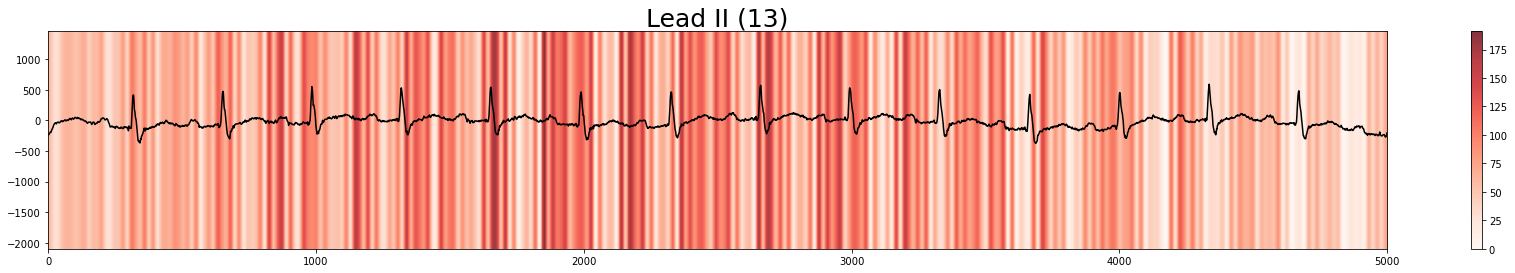

41


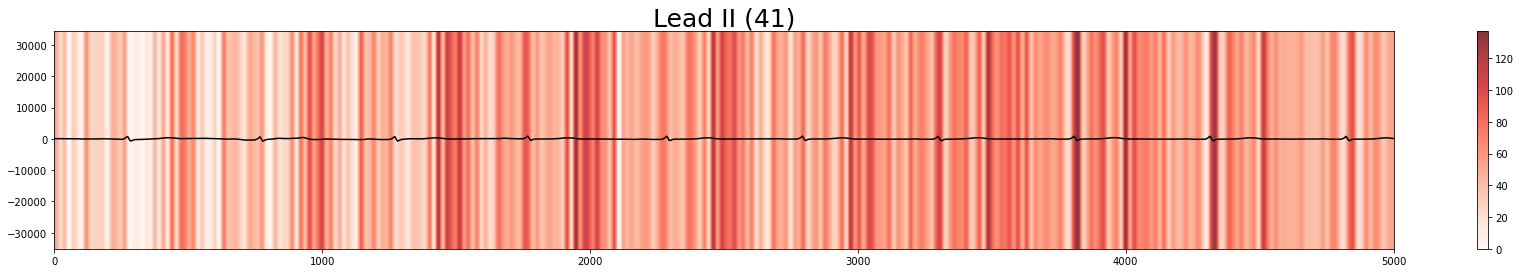

15


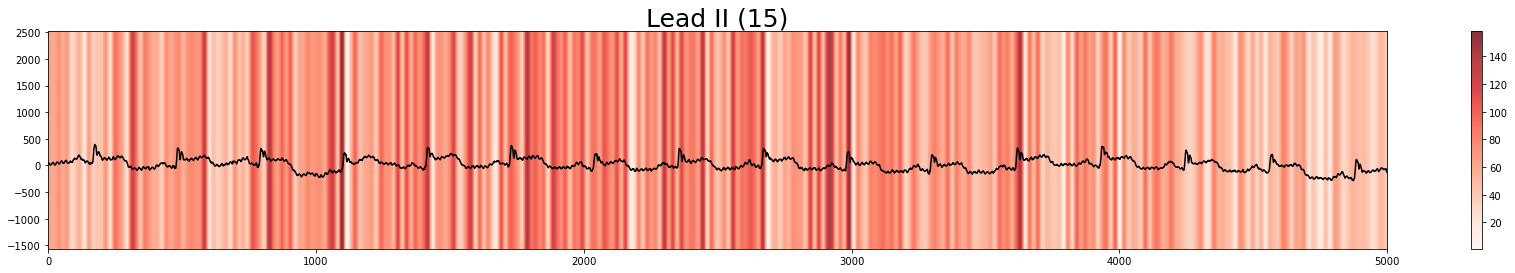

3


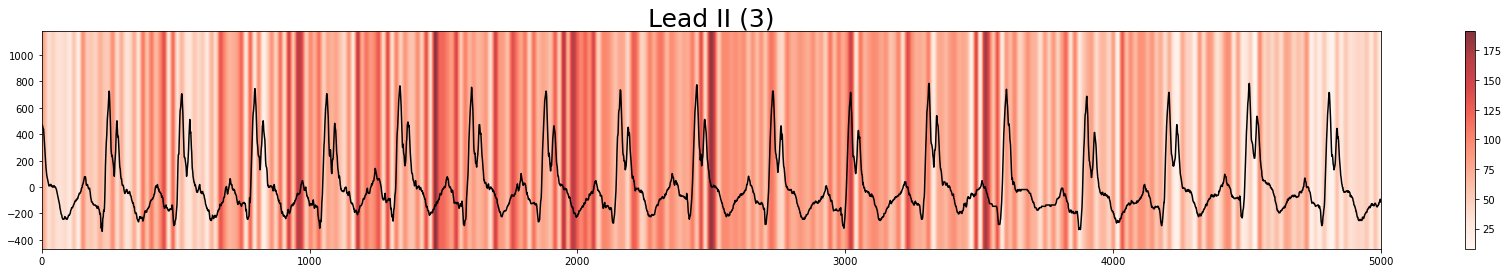

71


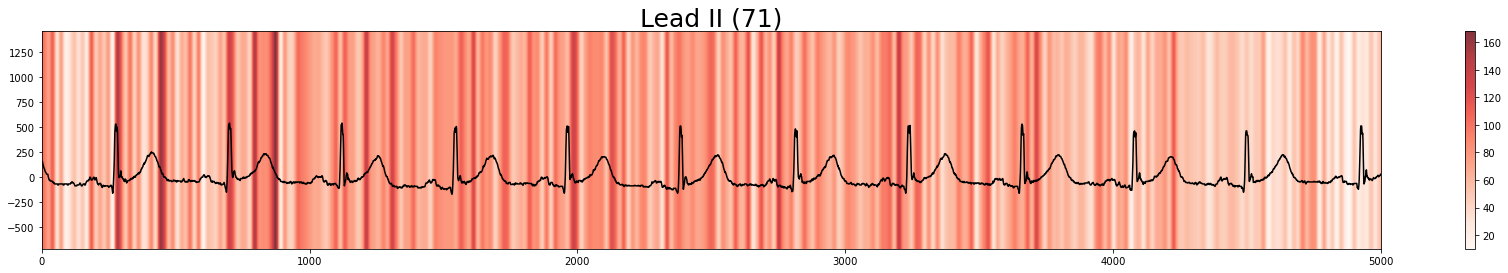

27


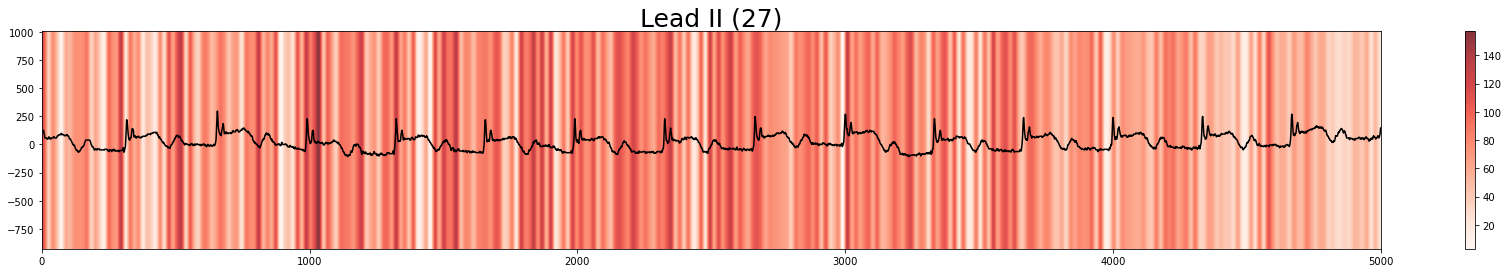

32


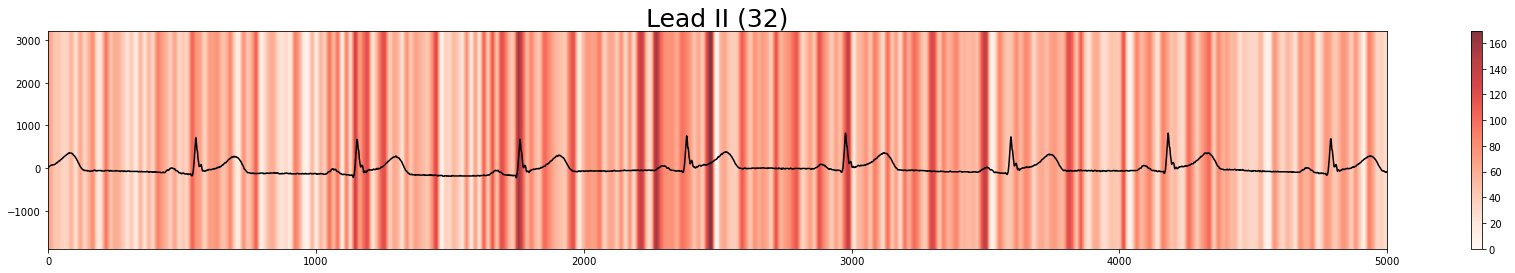

87


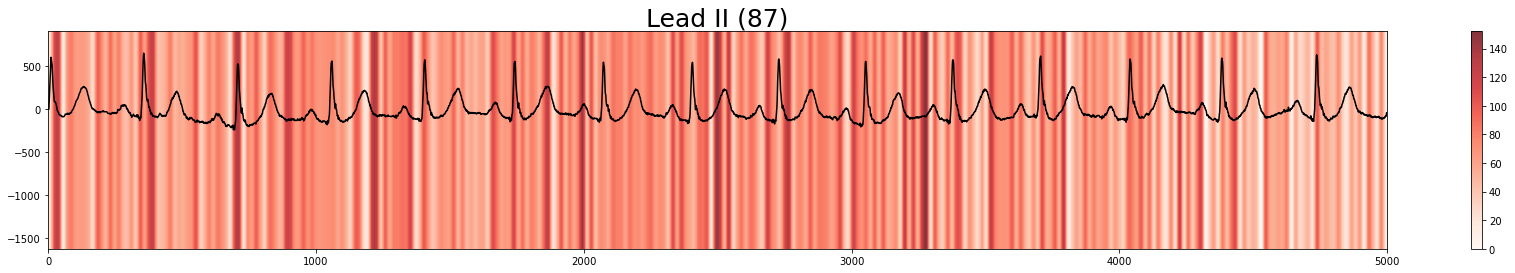

48


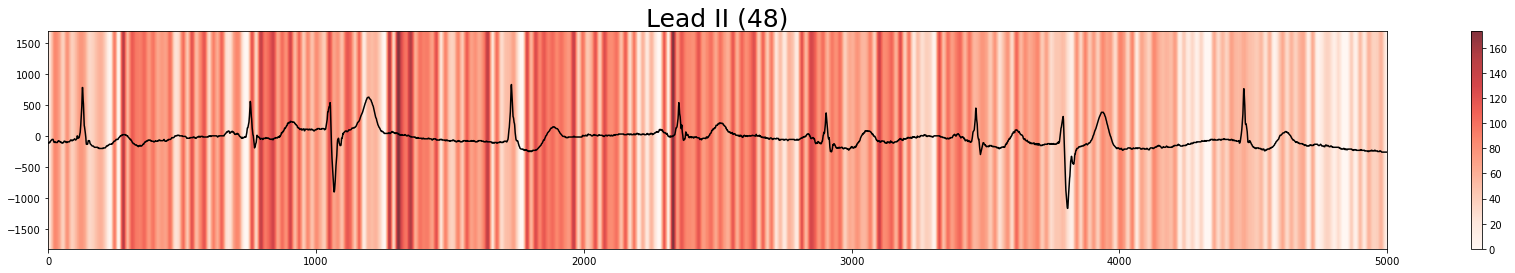

96


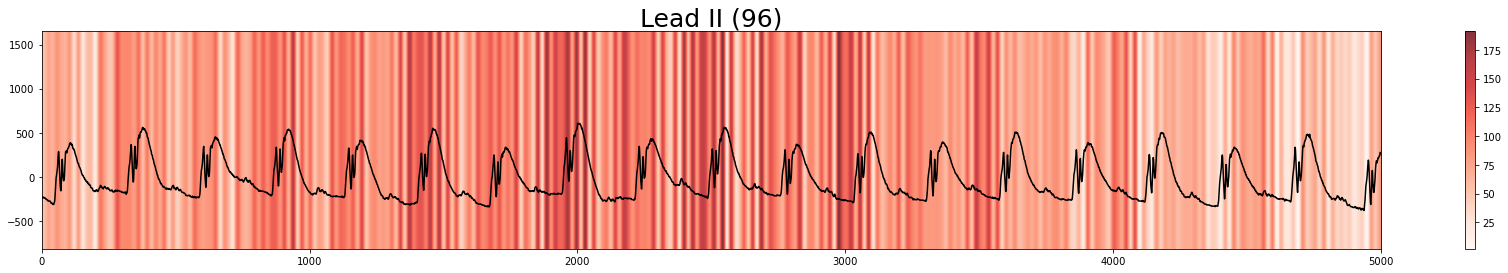

In [55]:
#i = 0
i += 10
gcperls(high_proba[i:i+10], 1) #lead II

In [48]:
hp_select = []
hp_select.append(3)

In [ ]:
for j in hp_select:
    print(j)
    show_waveform(j)

### 2) Low Probability of STEMI

81


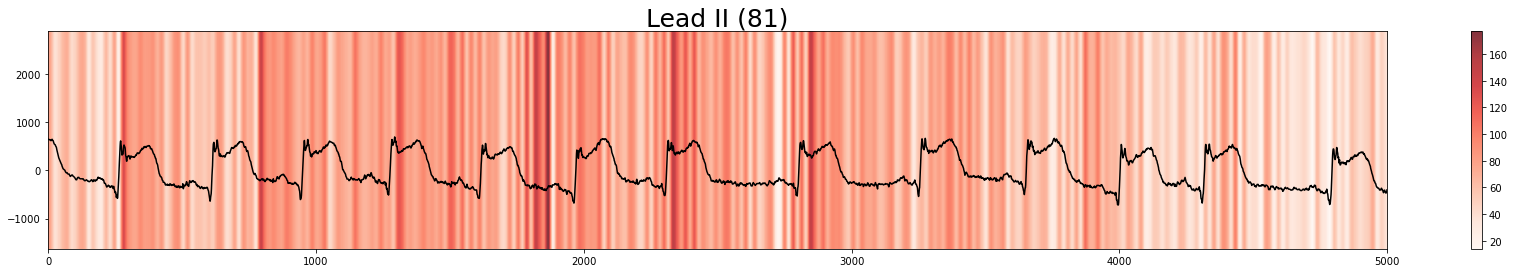

111


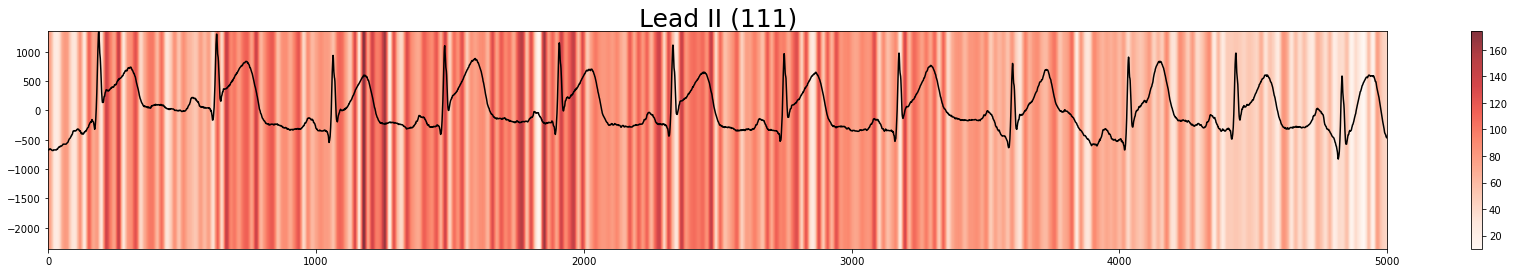

105


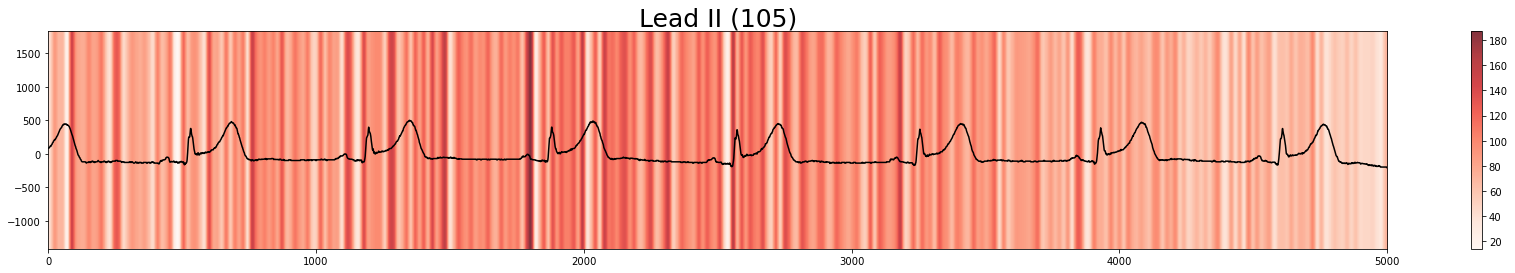

43


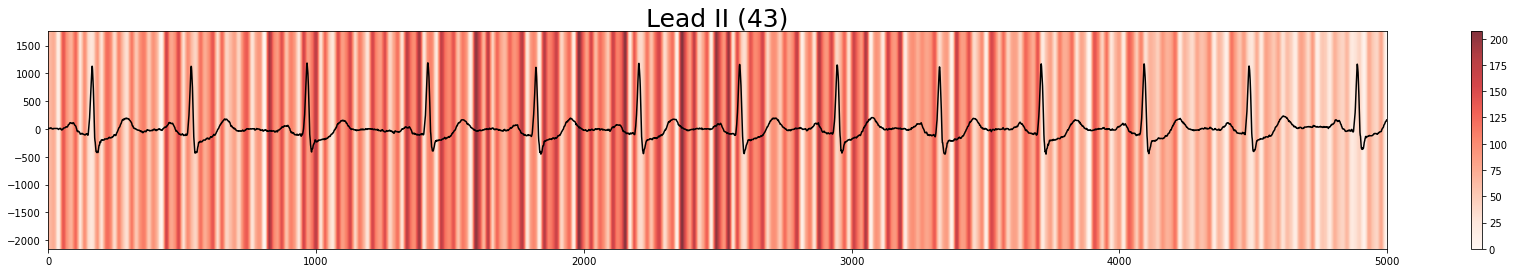

24


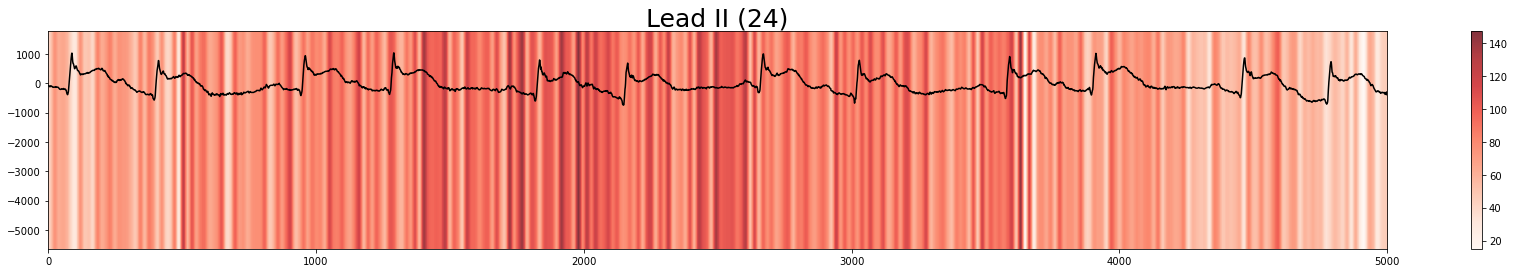

23


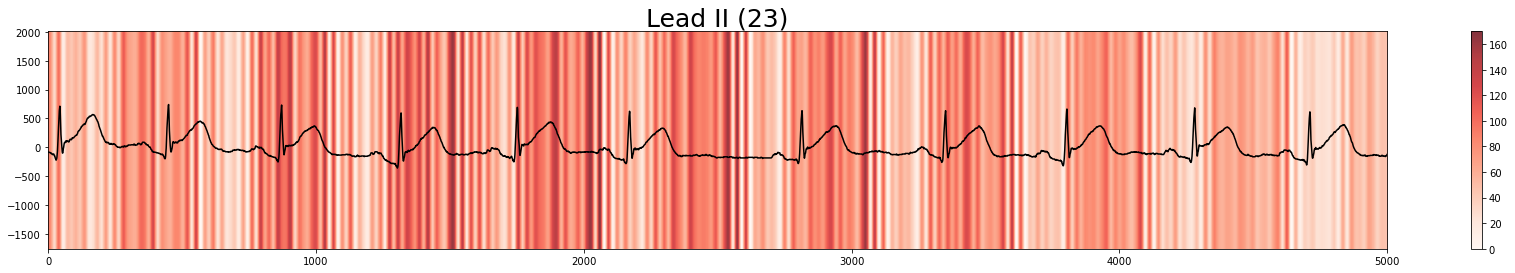

82


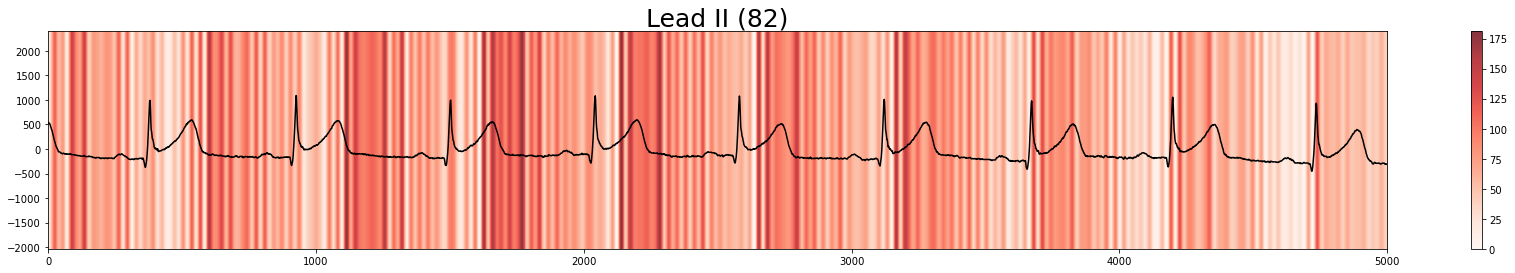

56


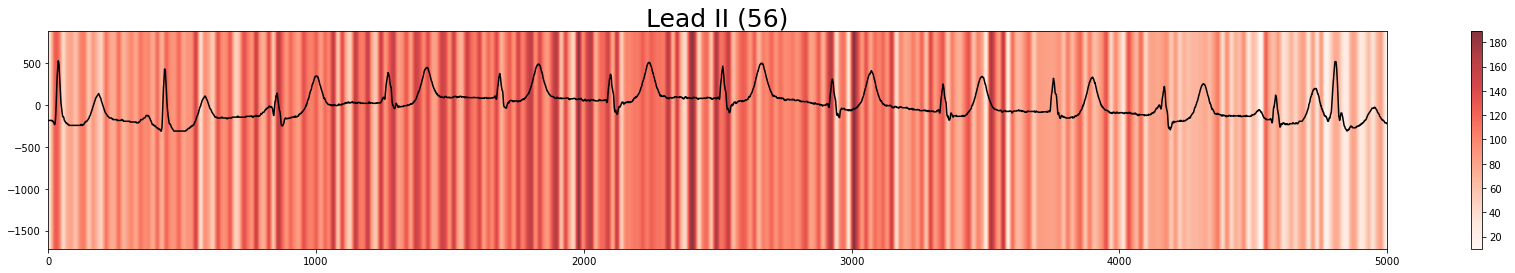

86


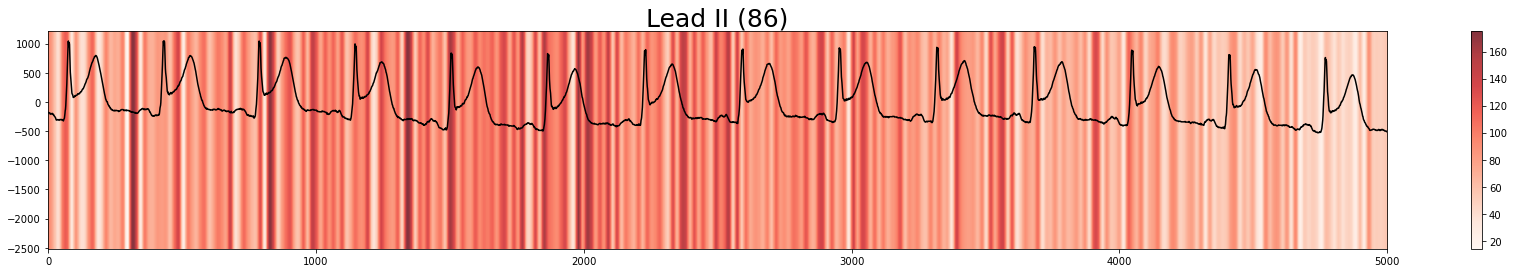

79


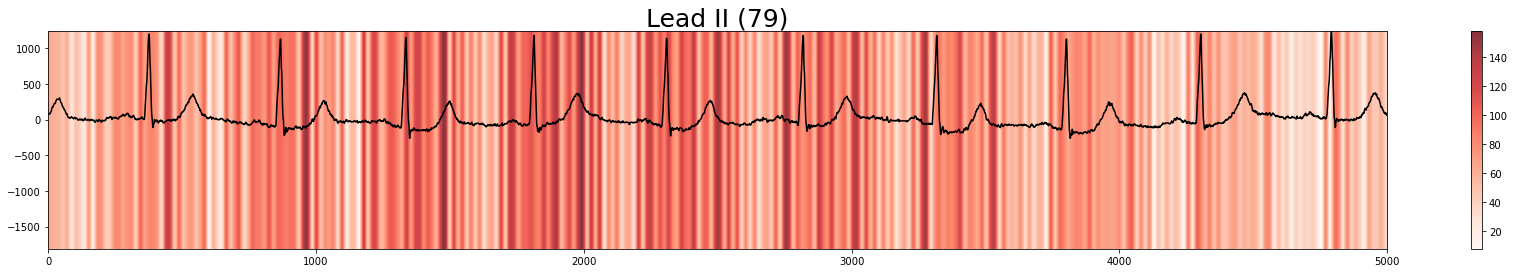

In [41]:
i = 0
#i += 10
gcperls(low_proba[i:i+10], 1) #lead II

In [45]:
lp_select = []
lp_select.append()

In [ ]:
for j in lp_select:
    print(j)
    show_waveform(j)

### 3) Confusion Matrix

### (1) FN

34


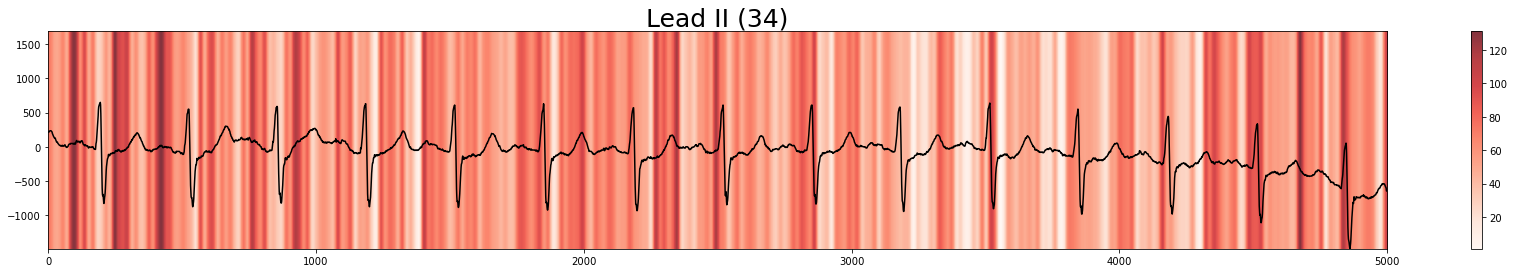

39


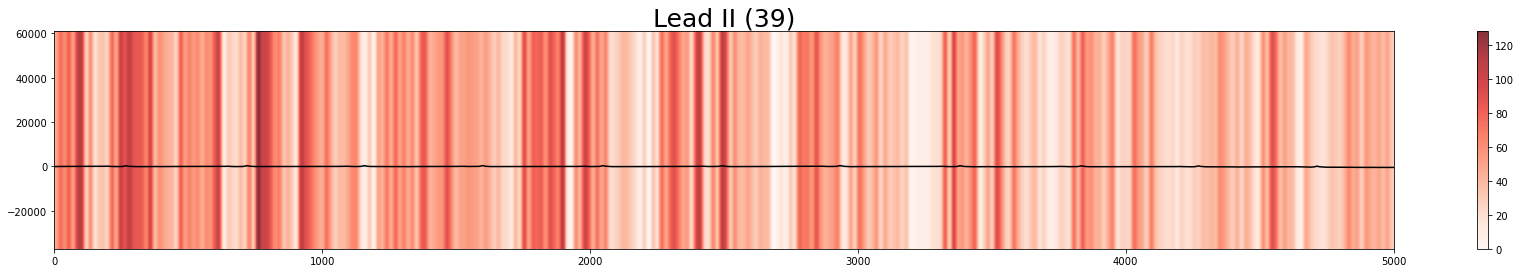

47


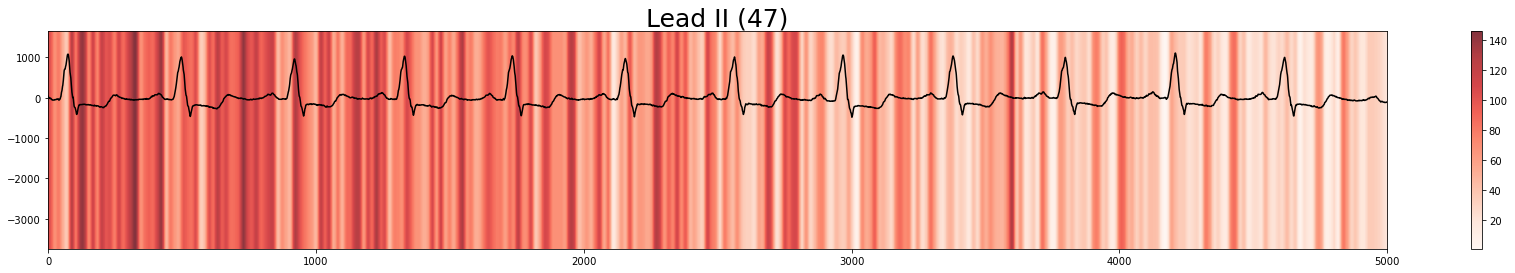

97


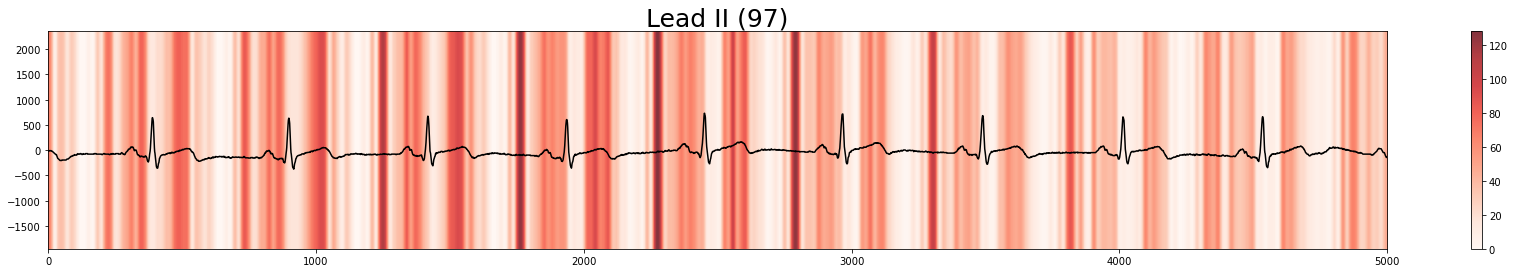

757


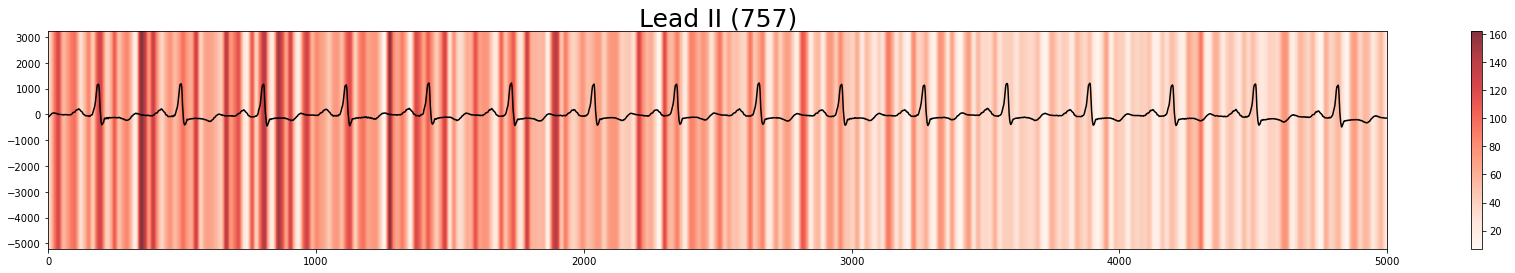

763


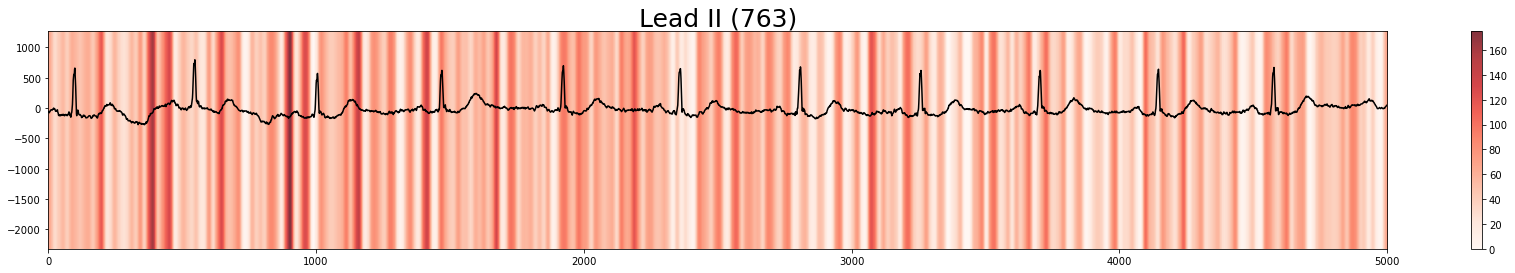

In [32]:
gcpercm(i_fn, 1) # FN, lead II

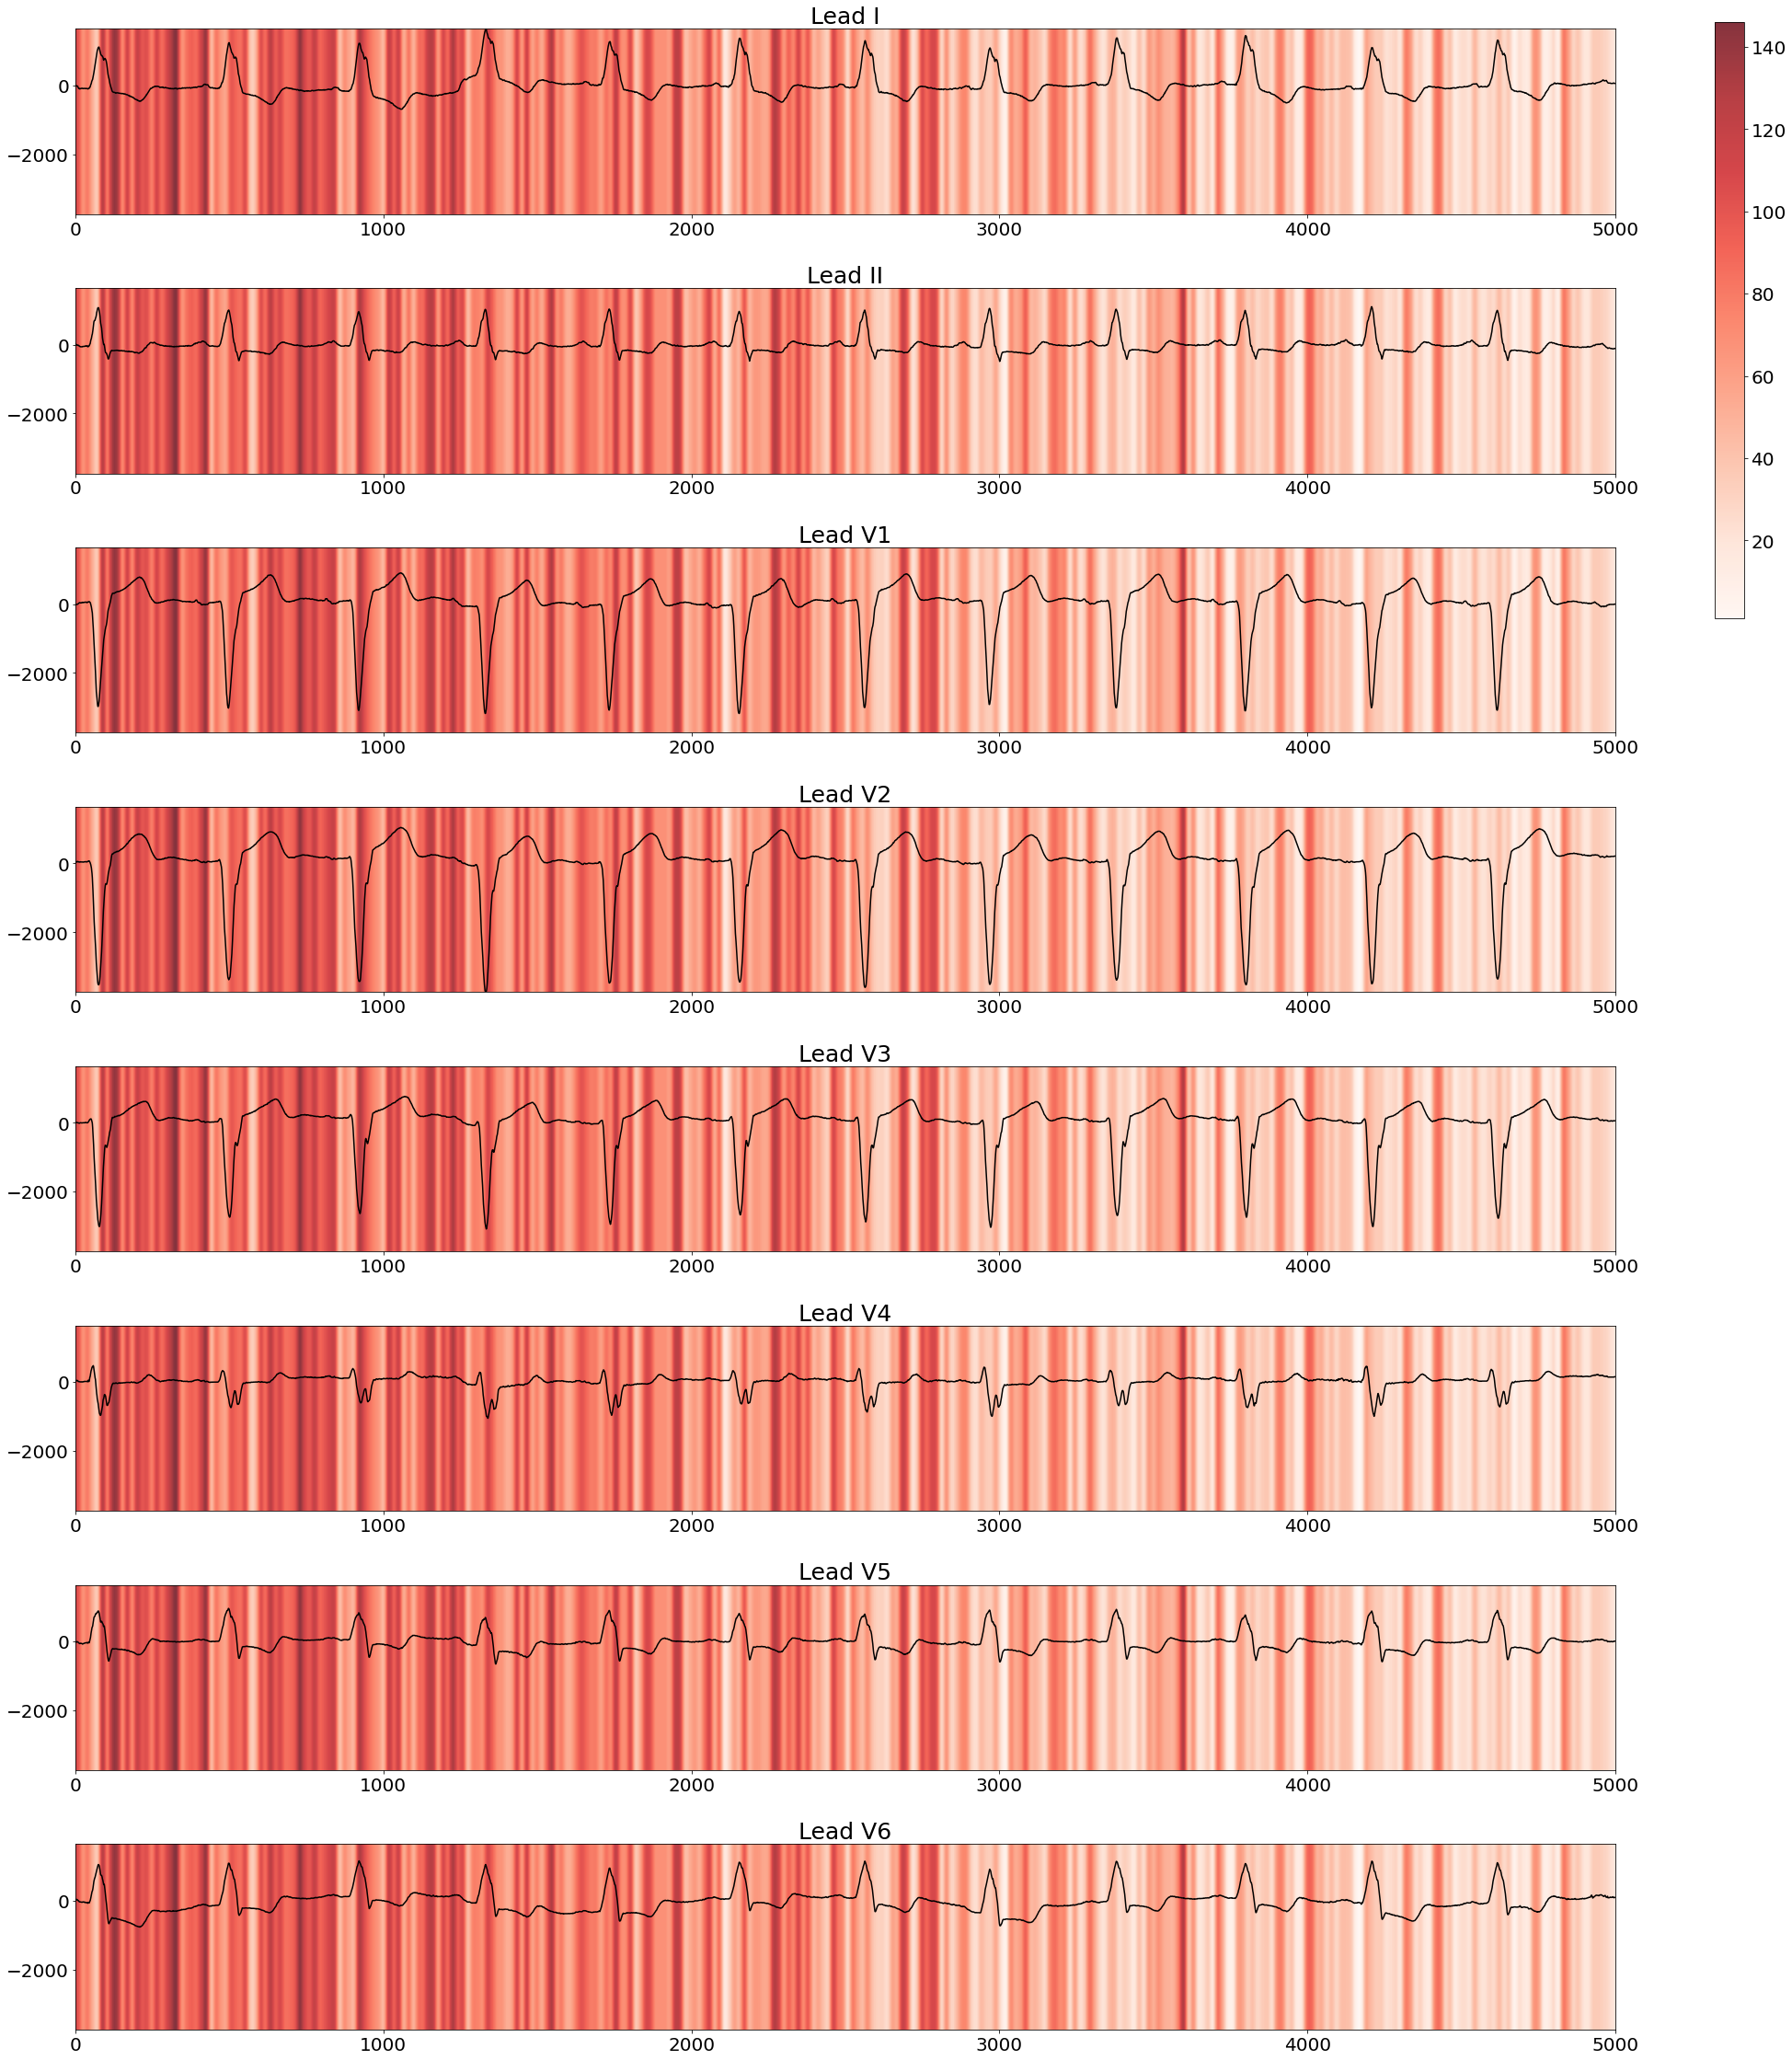

In [70]:
gcperlead(47)

### (2) FP

In [65]:
#i=0
i += 10
n_fp = i_fp[i:i+10]

207


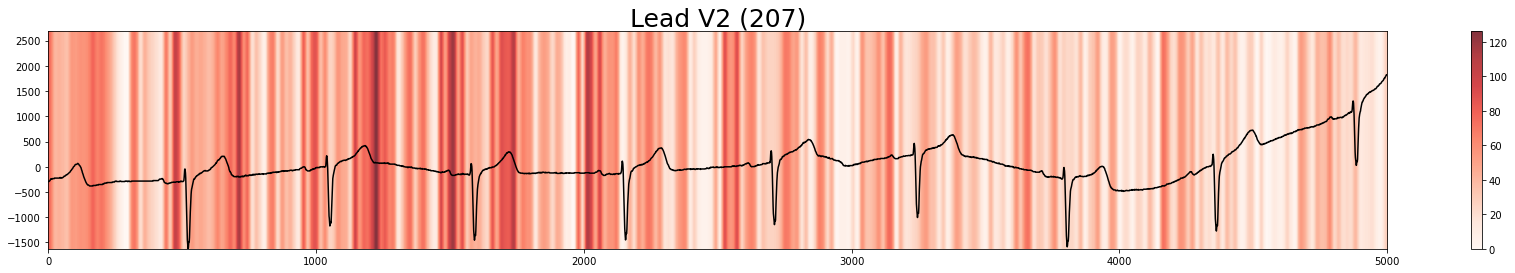

238


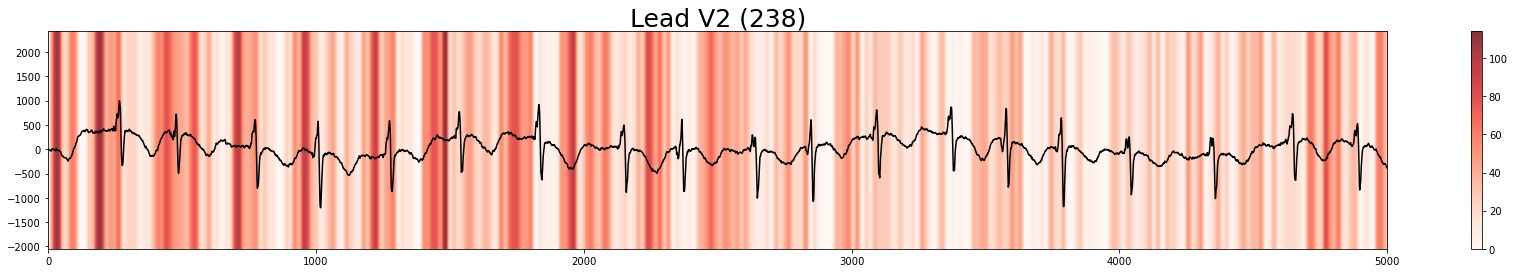

248


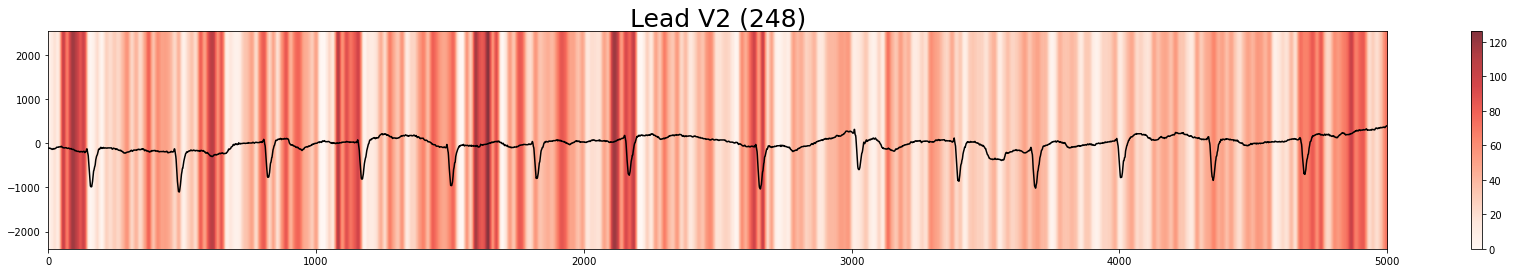

271


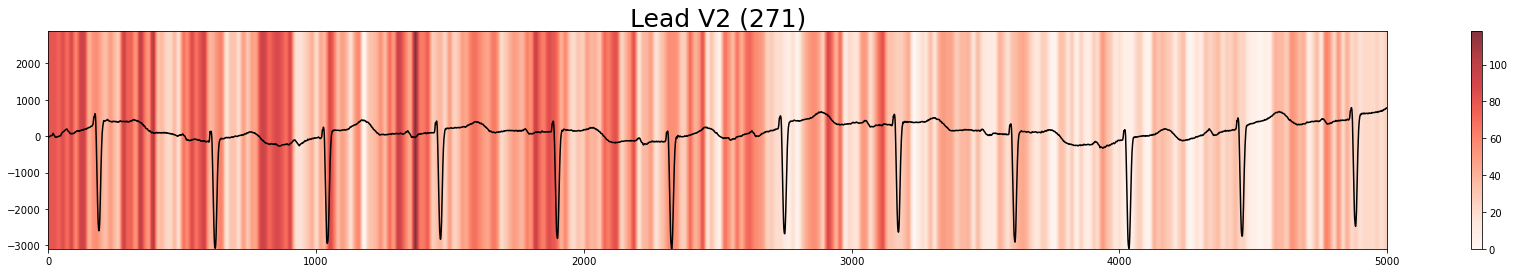

293


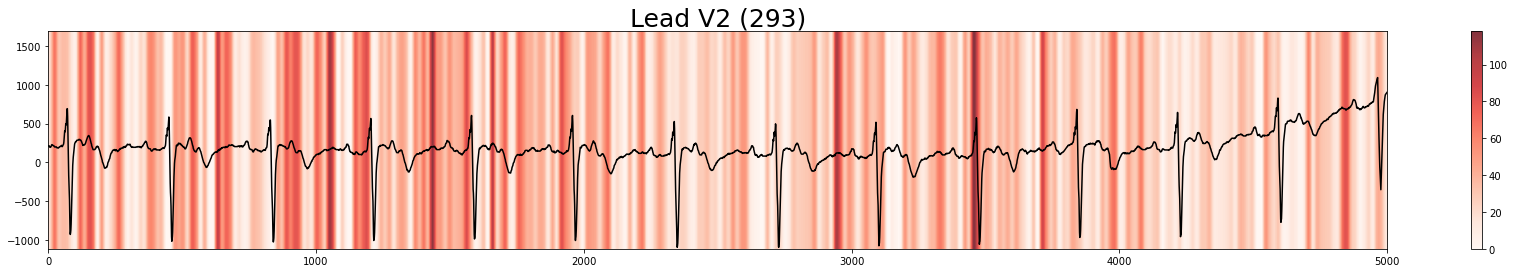

294


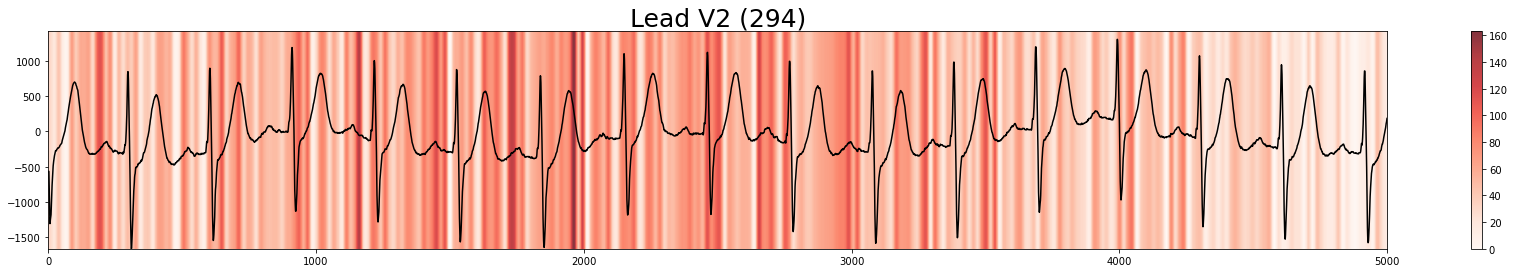

299


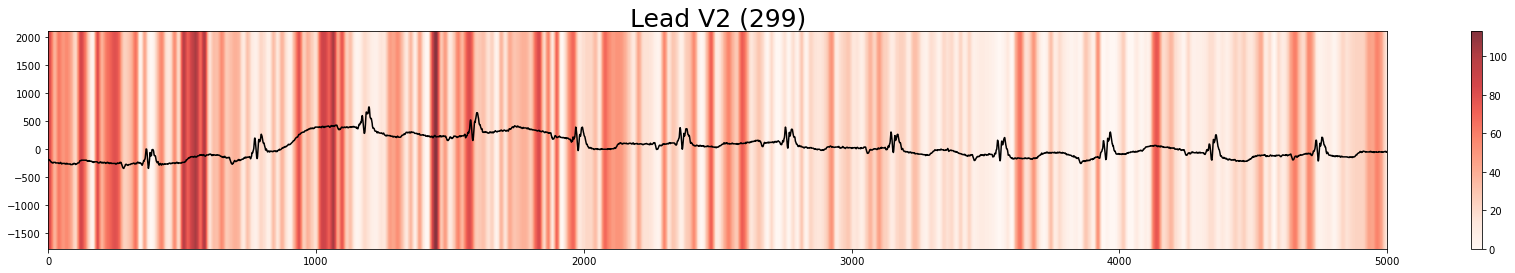

300


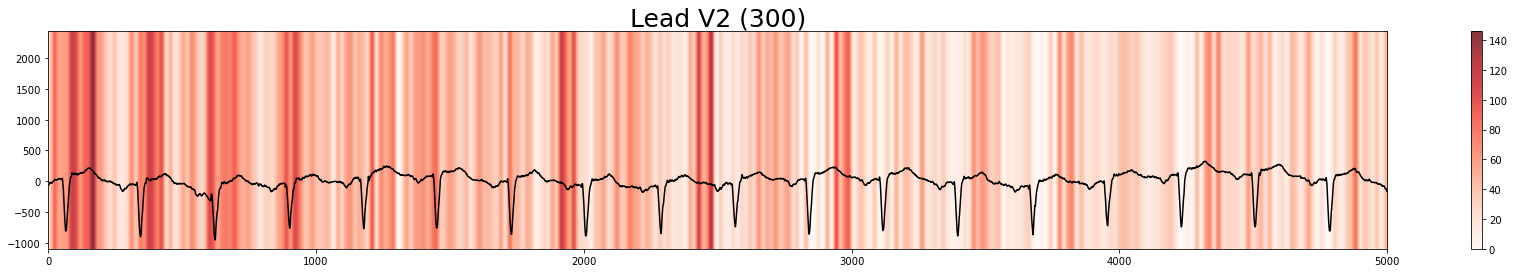

303


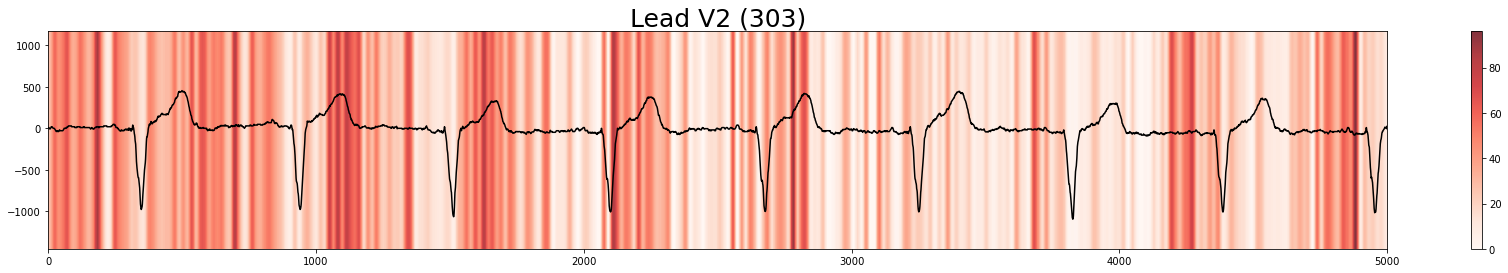

326


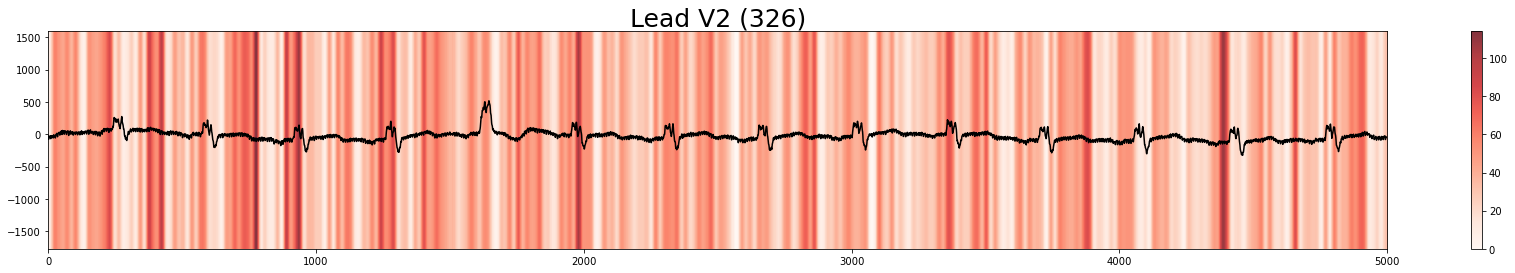

In [66]:
gcpercm(n_fp,3) # FP, lead II

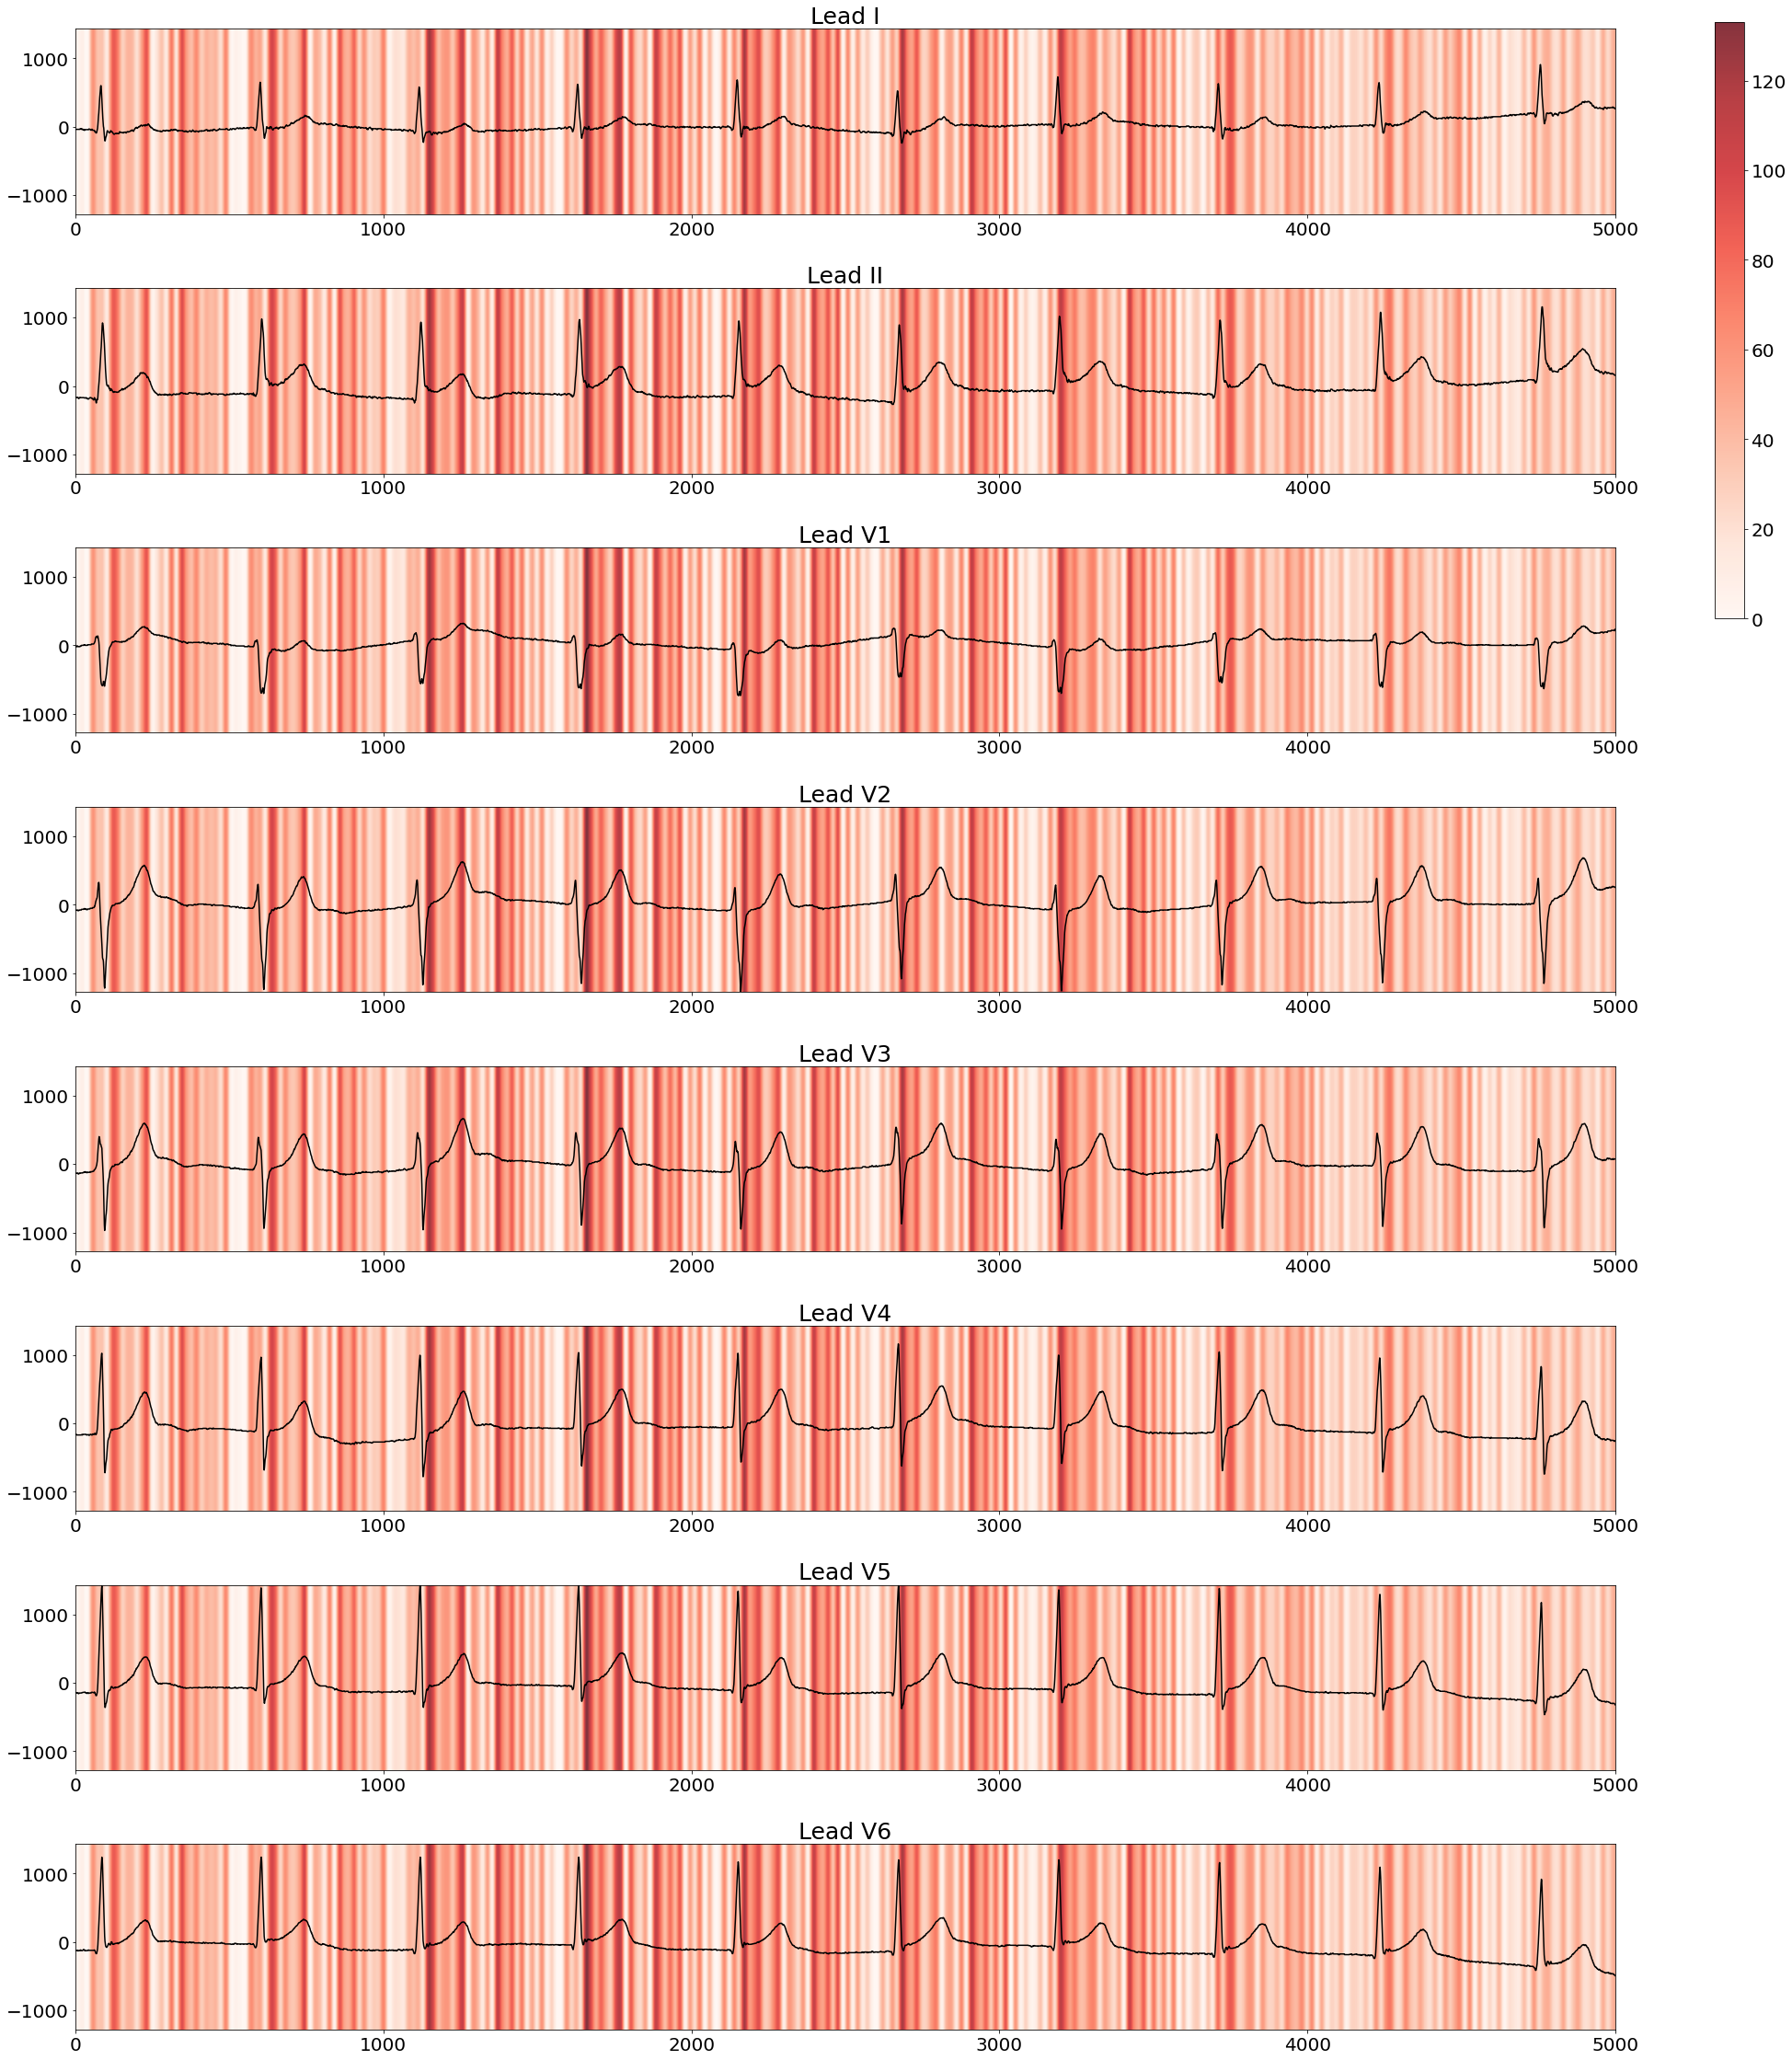

In [71]:
gcperlead(14)

### (3)TP

In [56]:
i=0
#i += 20
n_tp = i_tp[i:i+20]

0


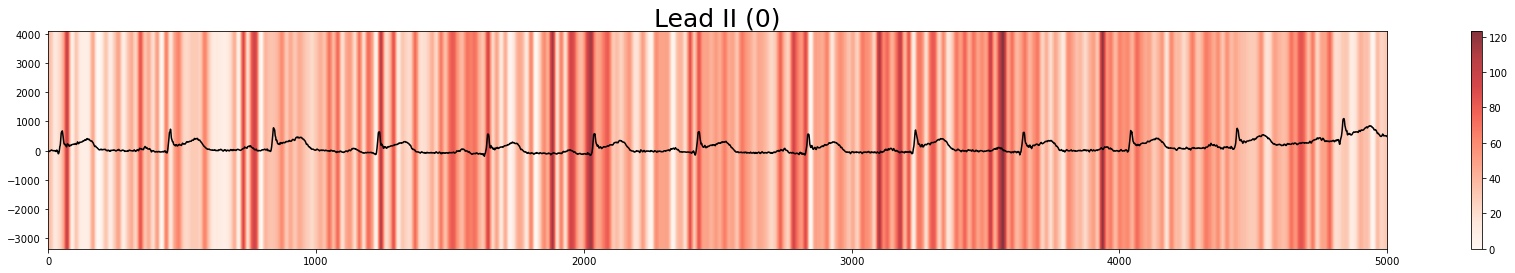

1


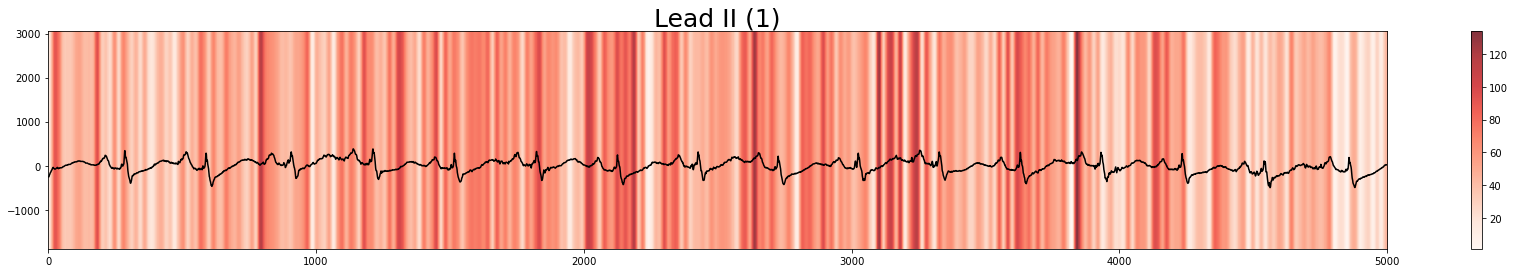

3


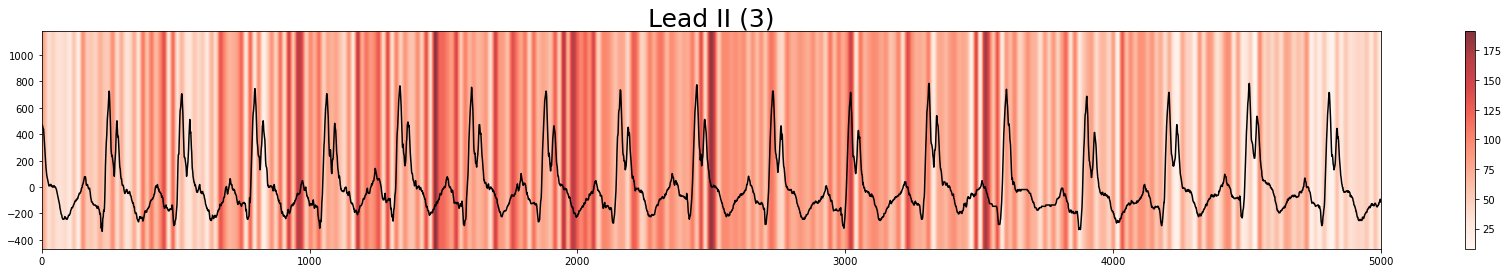

4


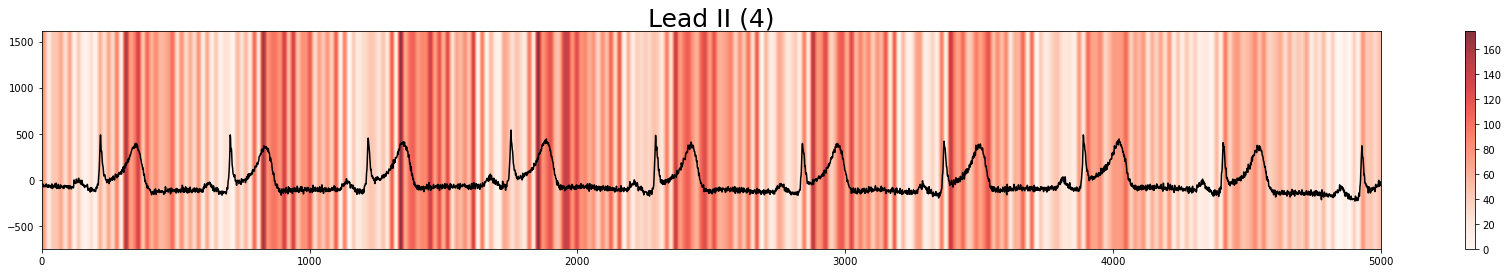

5


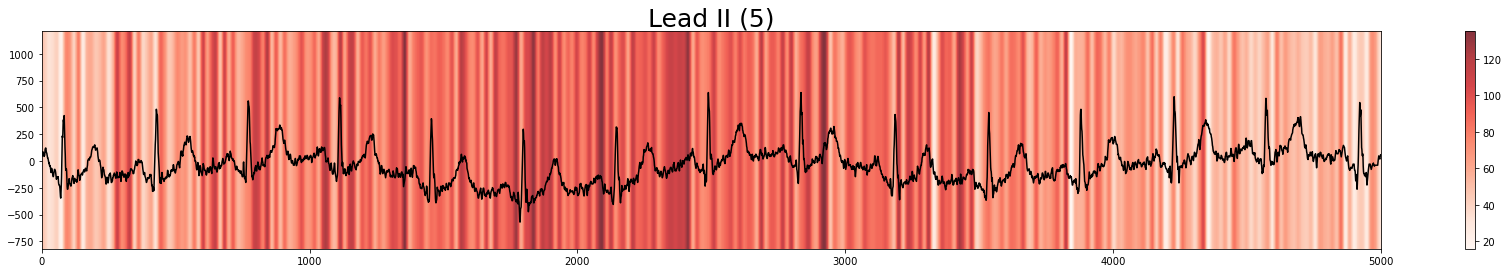

6


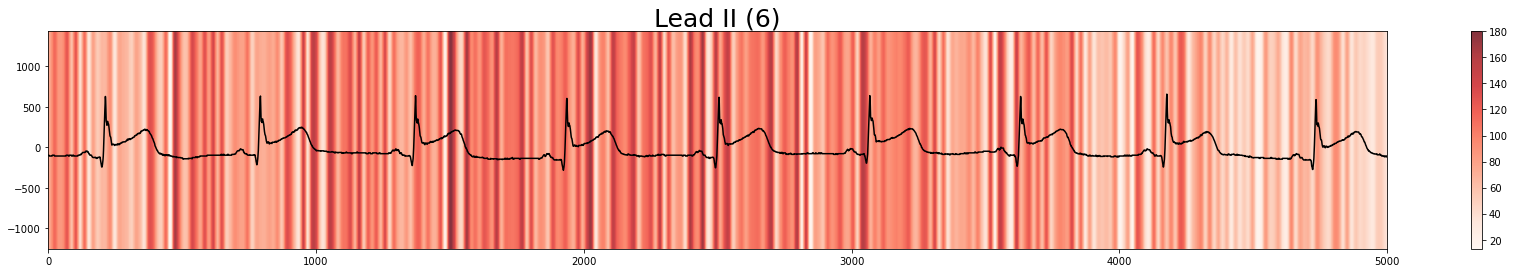

7


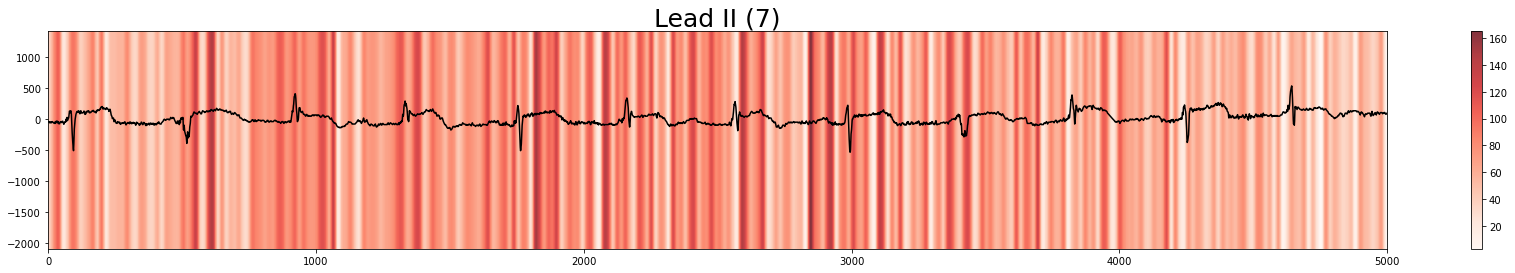

8


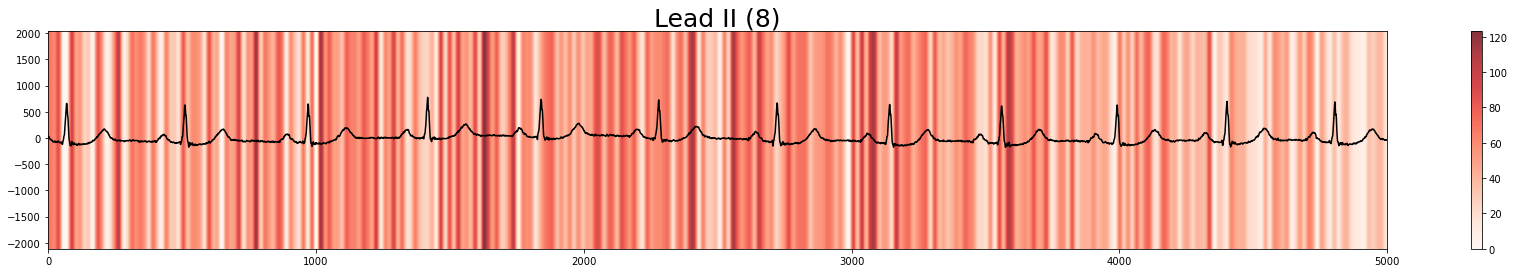

9


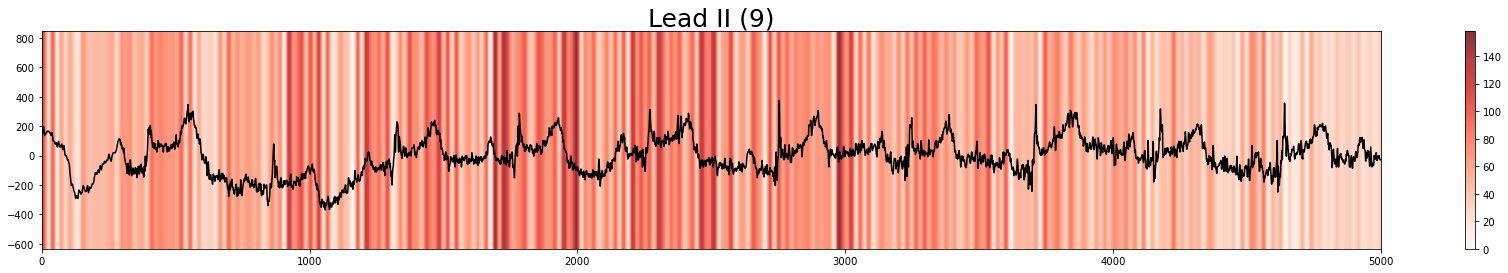

10


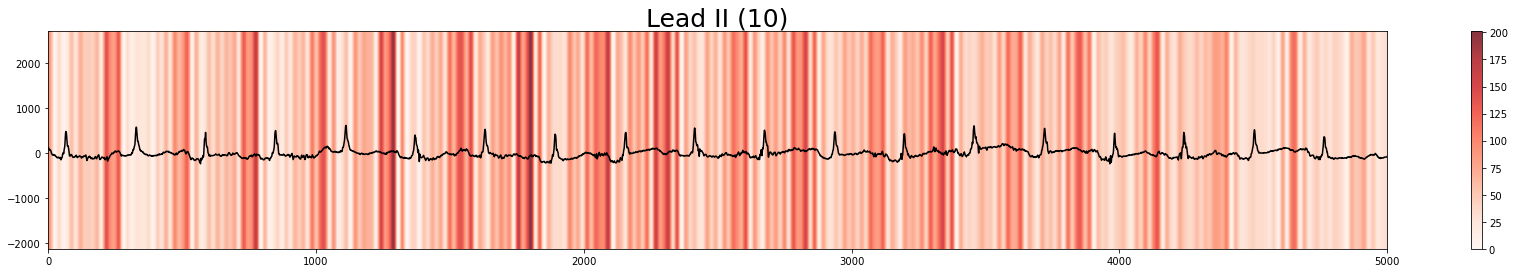

11


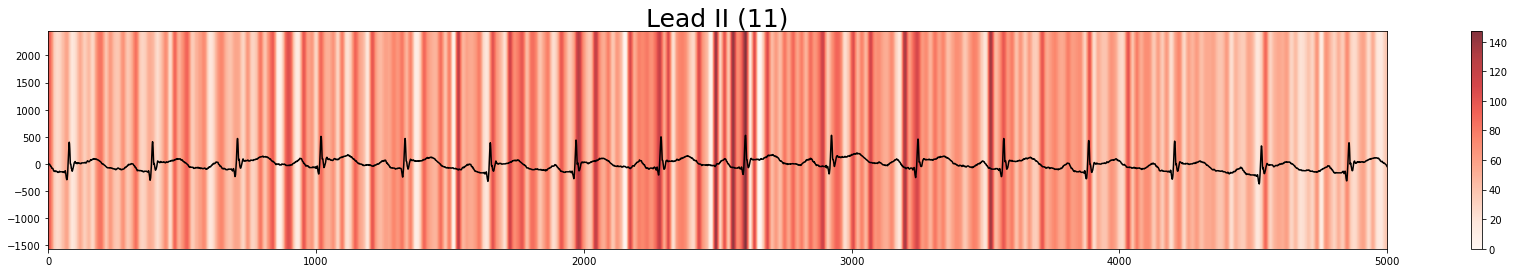

12


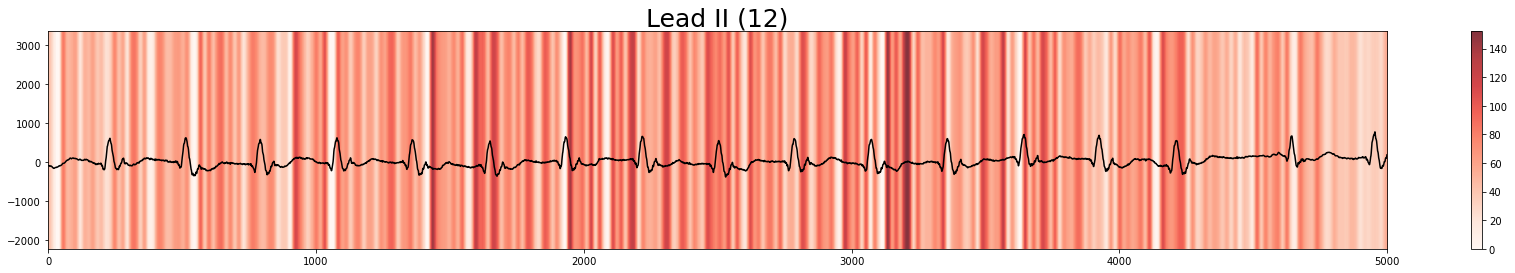

13


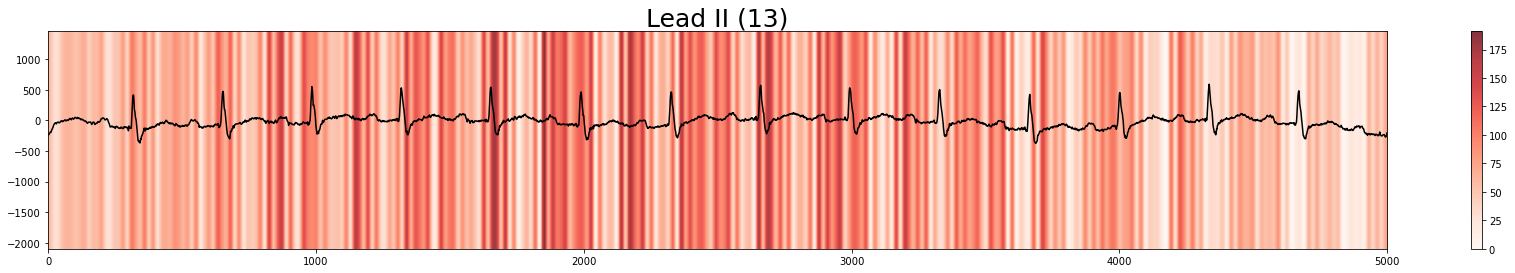

14


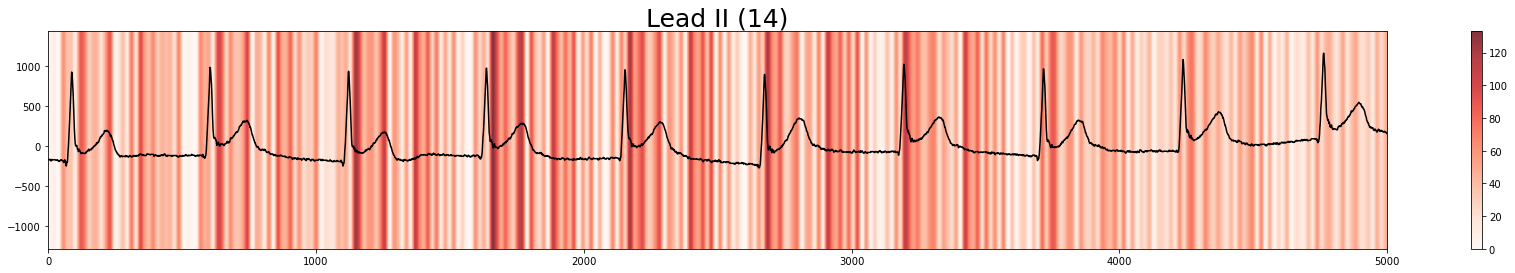

15


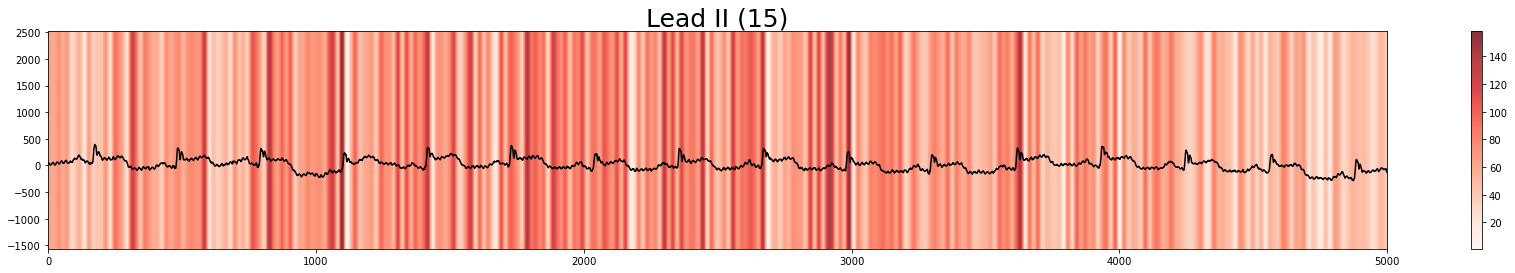

16


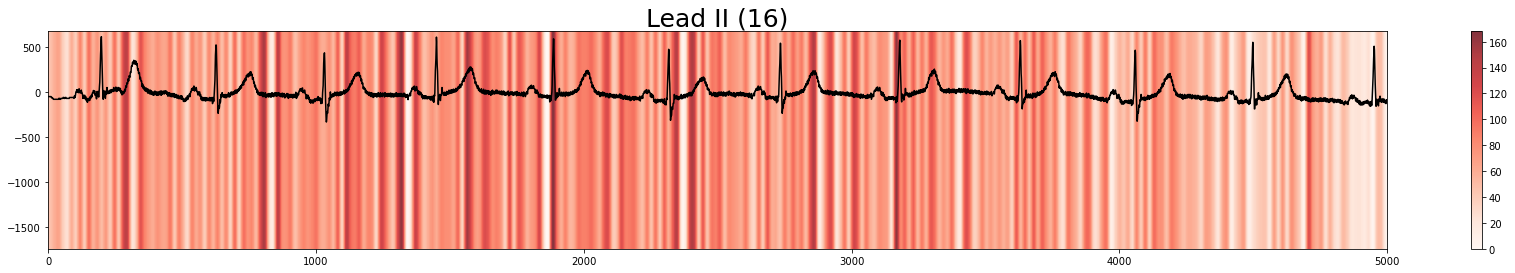

17


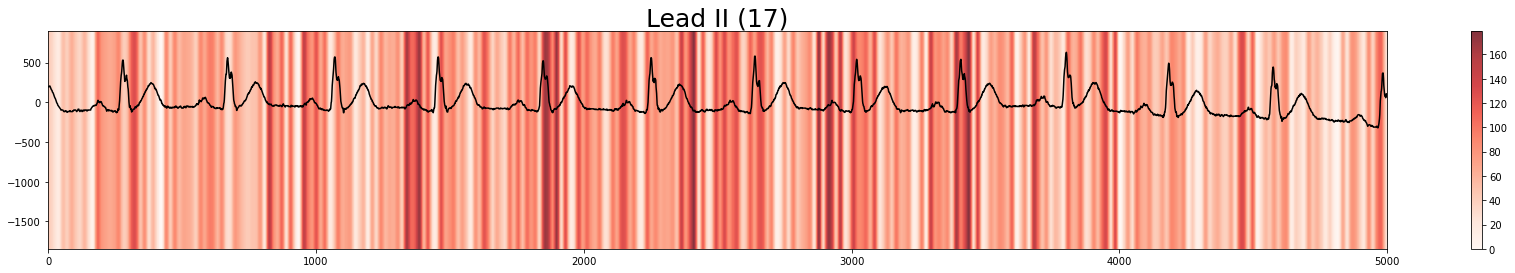

18


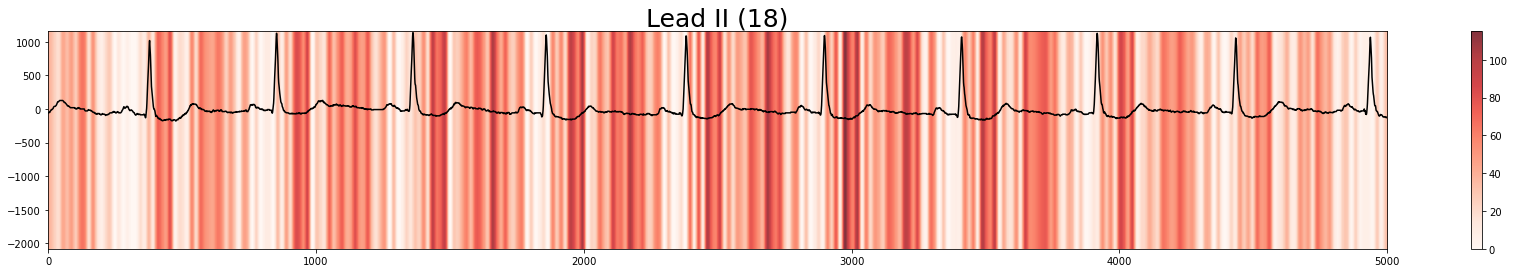

19


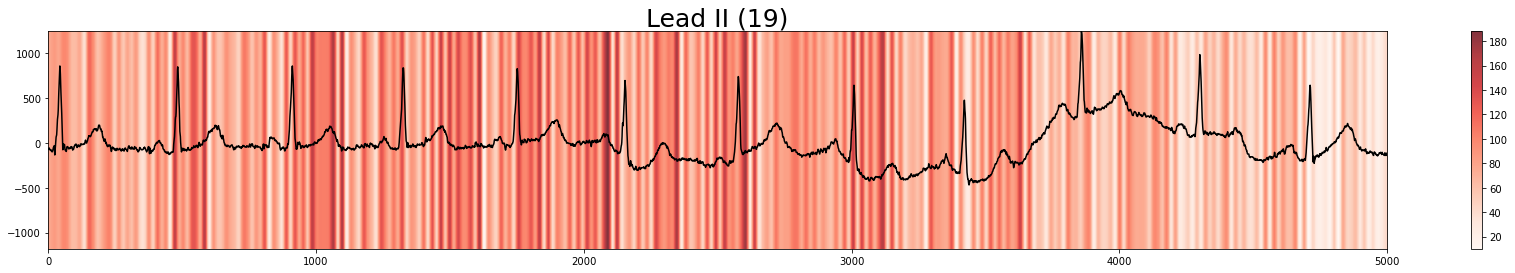

20


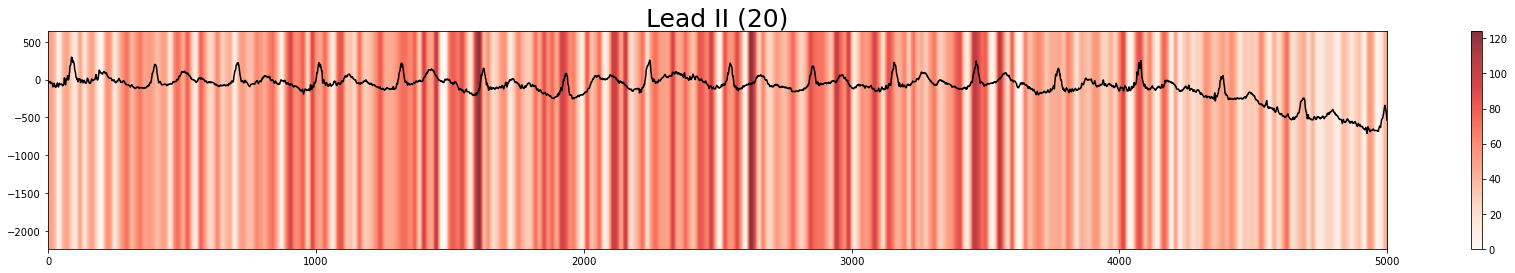

In [57]:
gcpercm(n_tp,1) # TP, lead II

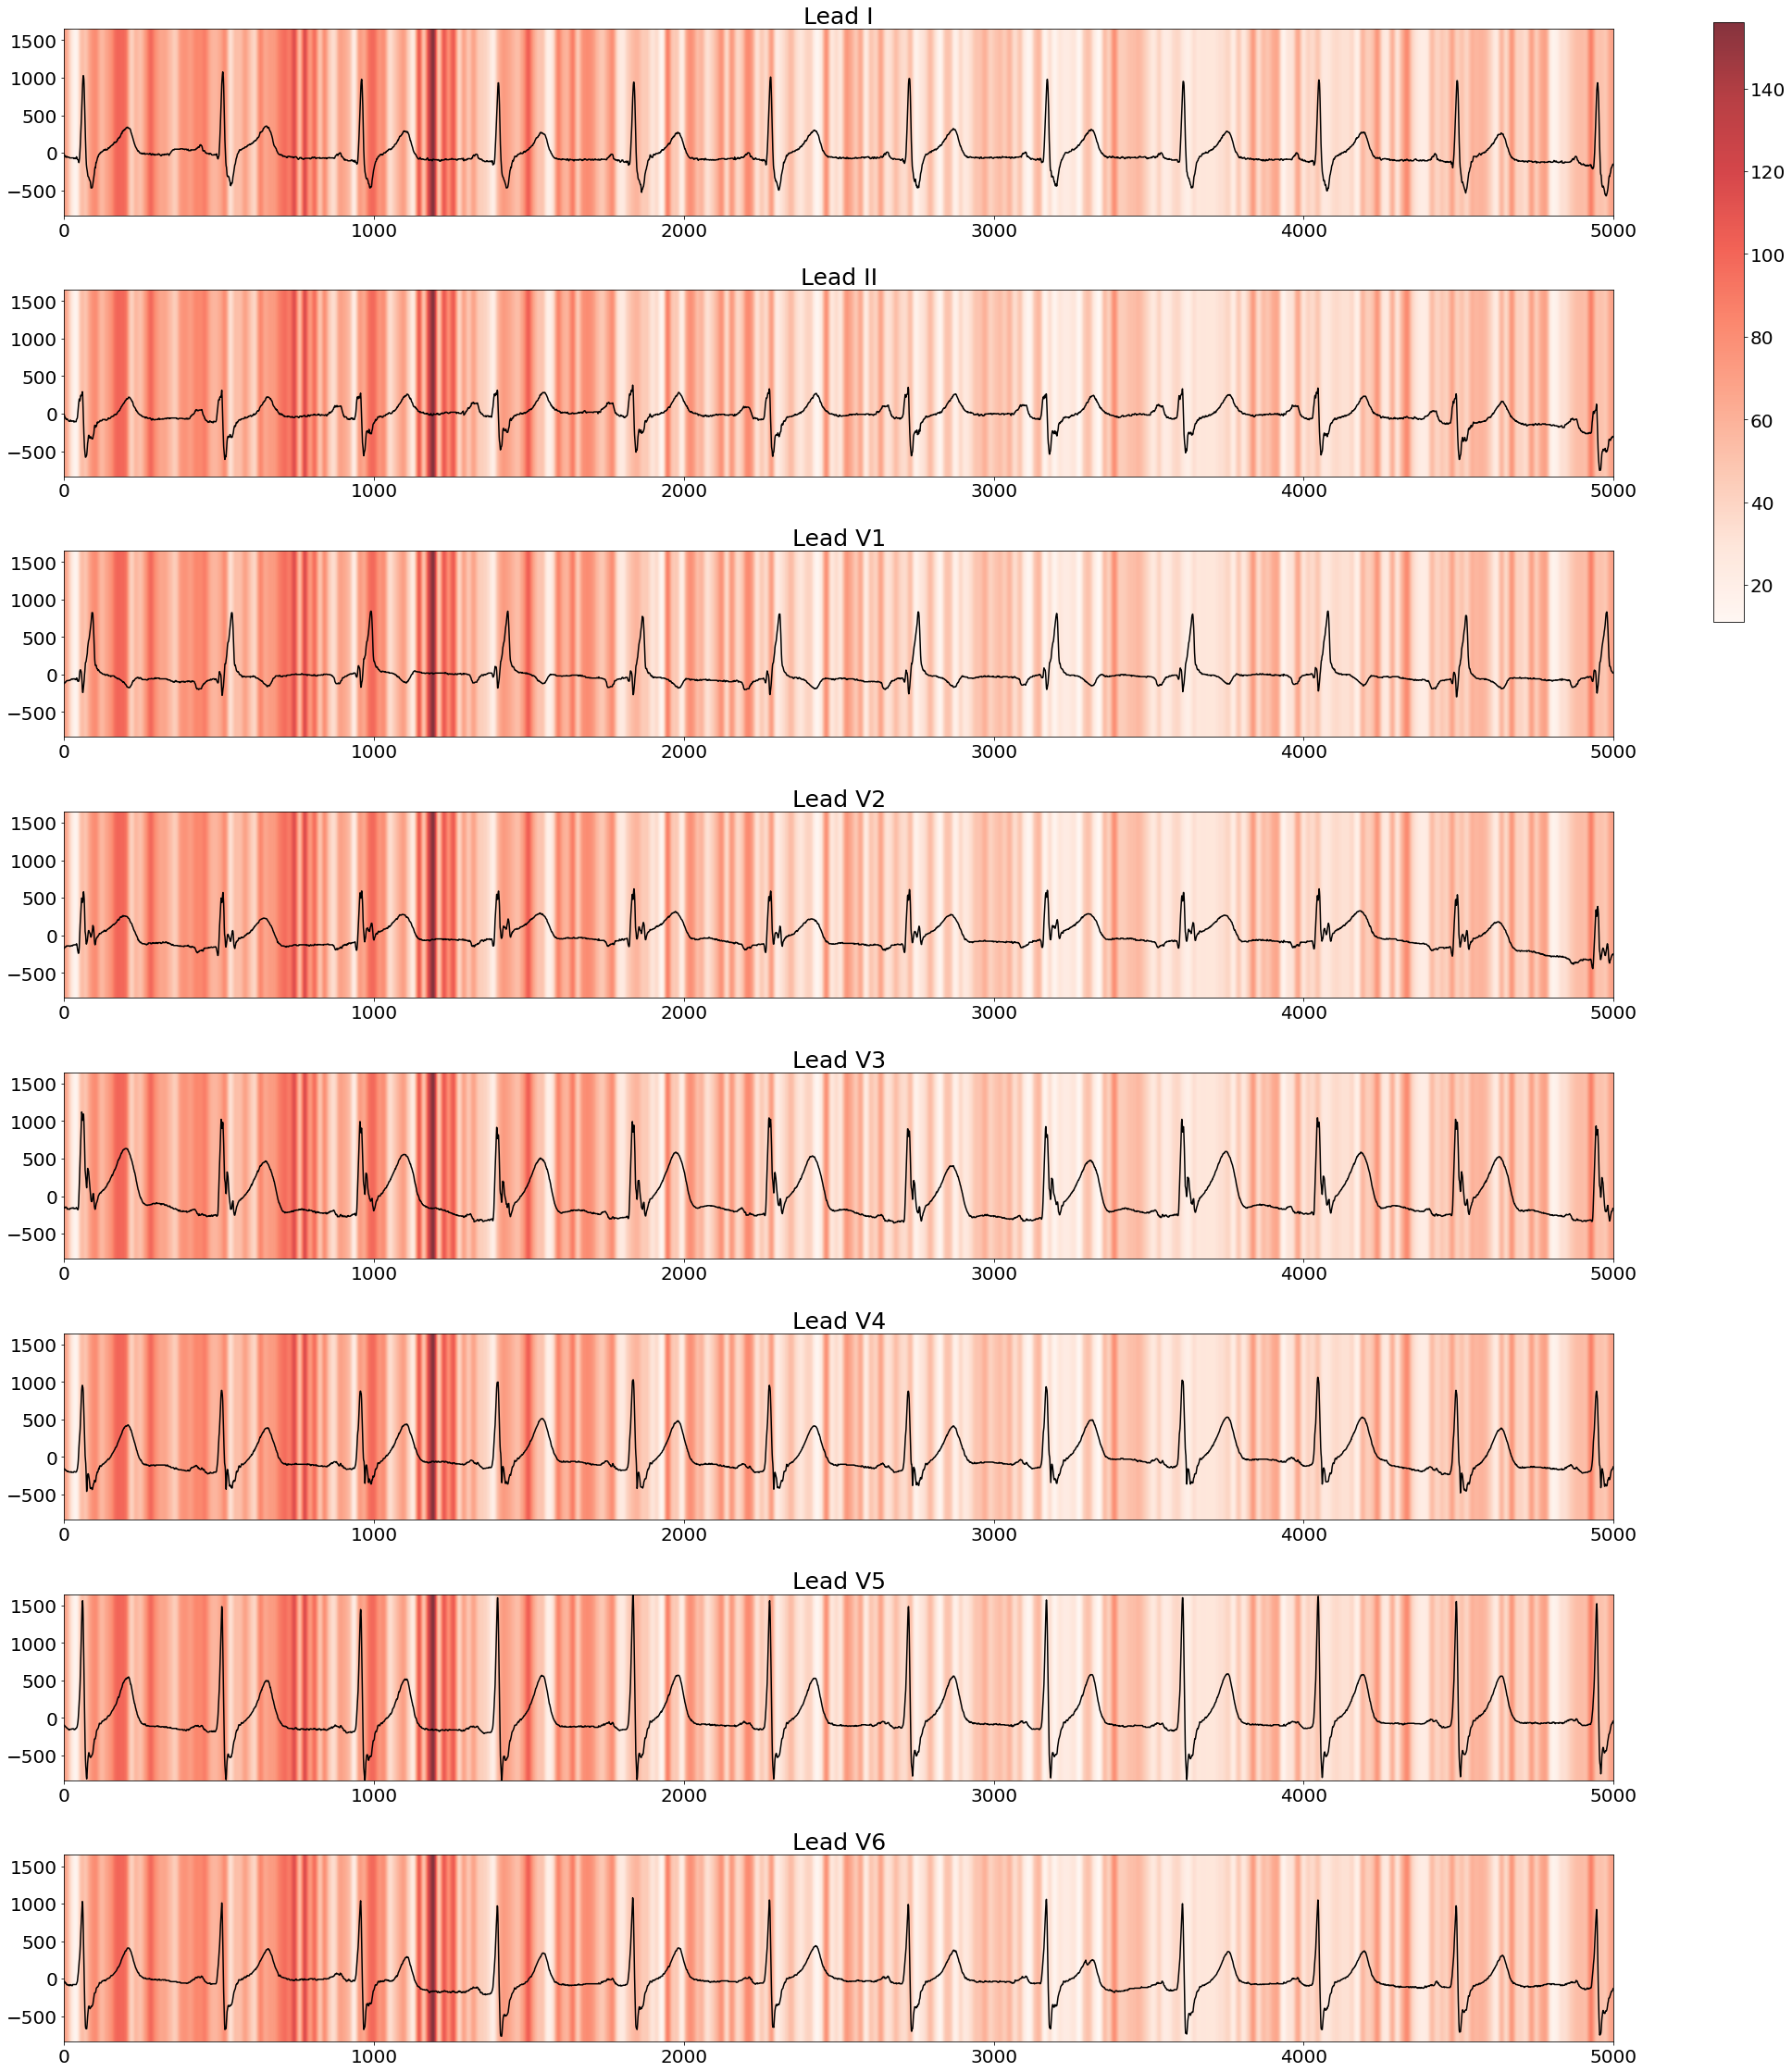

In [77]:
gcperlead(181)

147


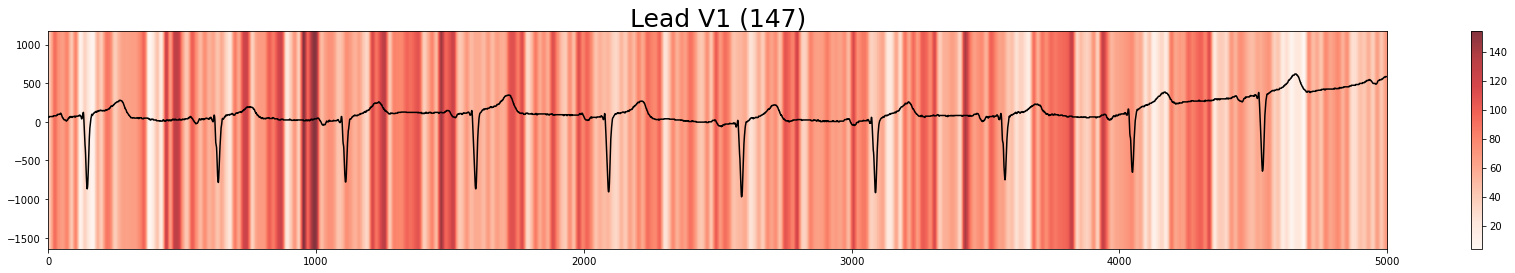

In [94]:
gcpercm([147],2) #1: leadII, 2: V1

In [95]:
itp.to_list()

[0,
 1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 35,
 36,
 37,
 38,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 557,
 880,
 924,
 1060,
 1130,
 1147,
 1238,
 1315,
 1316,
 1317]

### (4) TN

In [68]:
i=0
#i += 20
n_tn = i_tn[i:i+20]

70


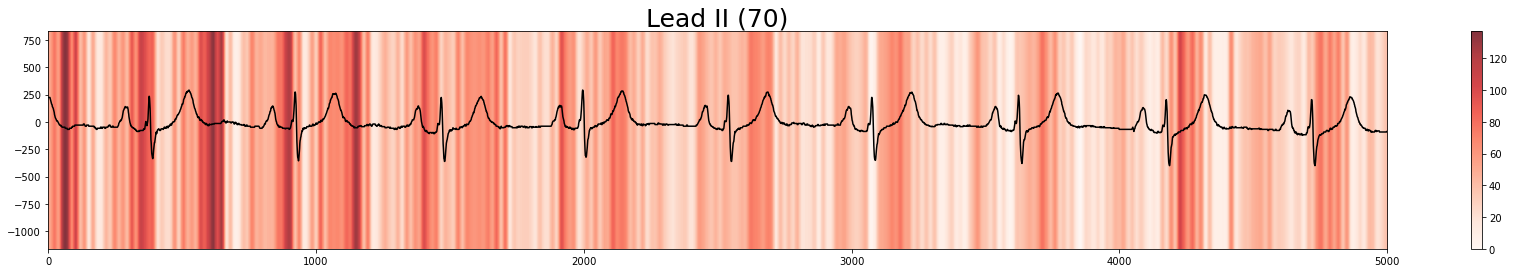

120


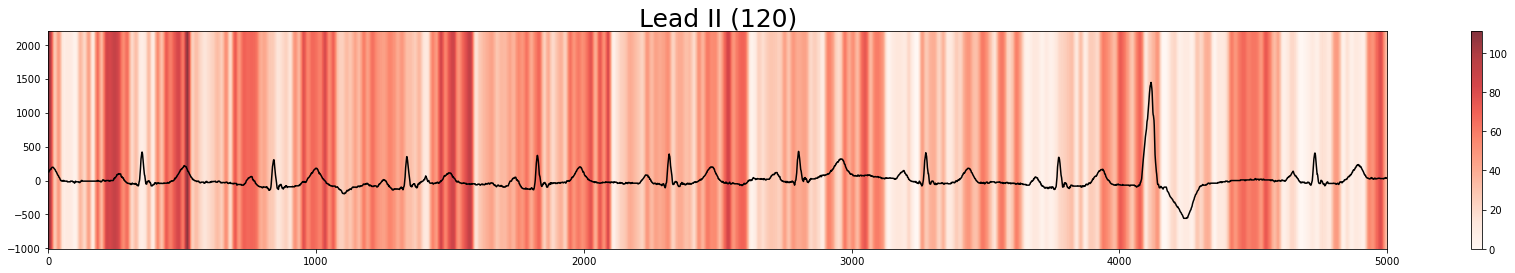

121


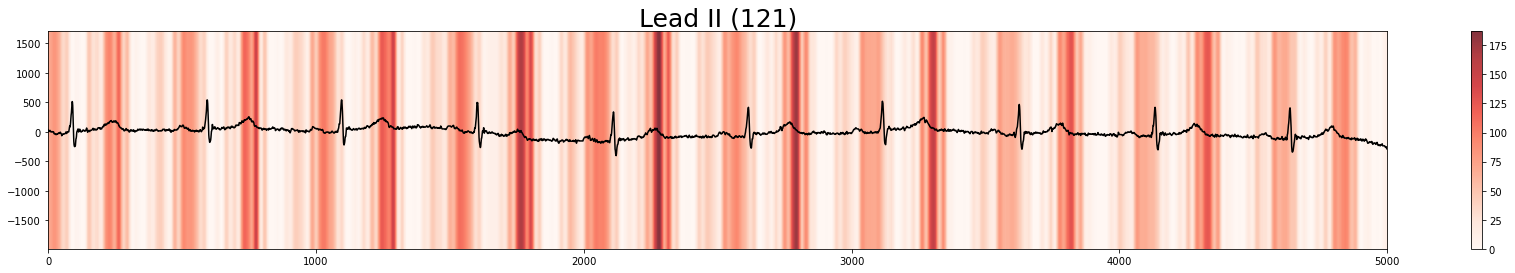

123


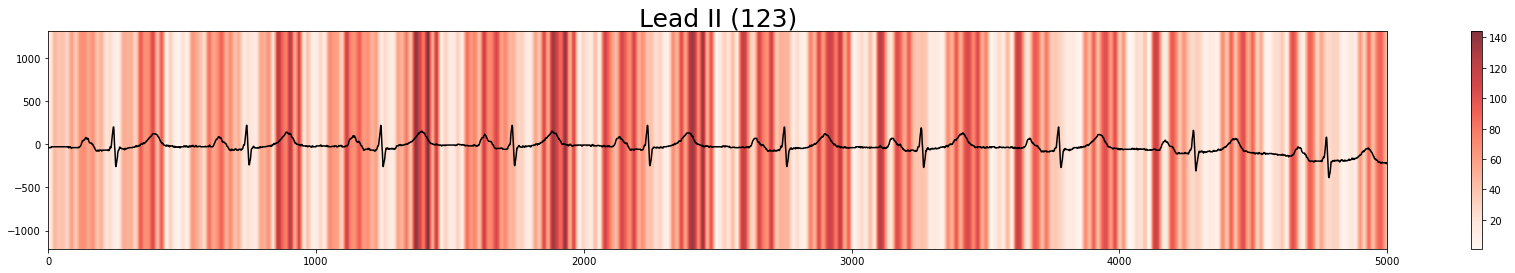

124


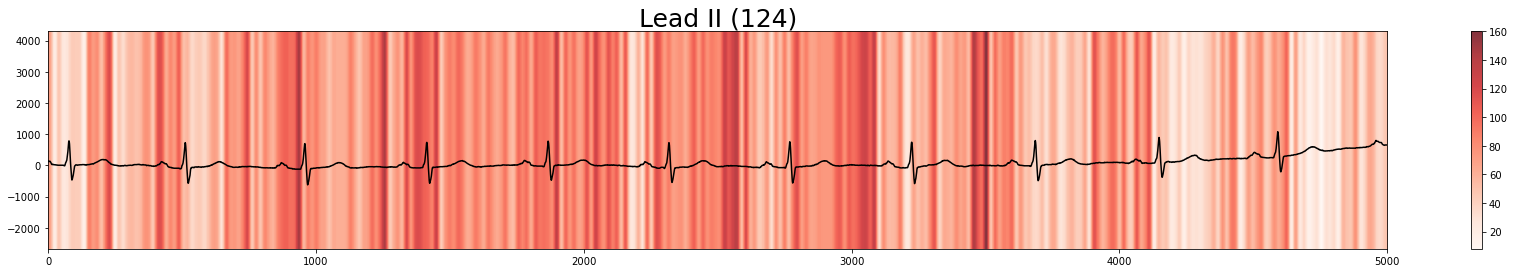

125


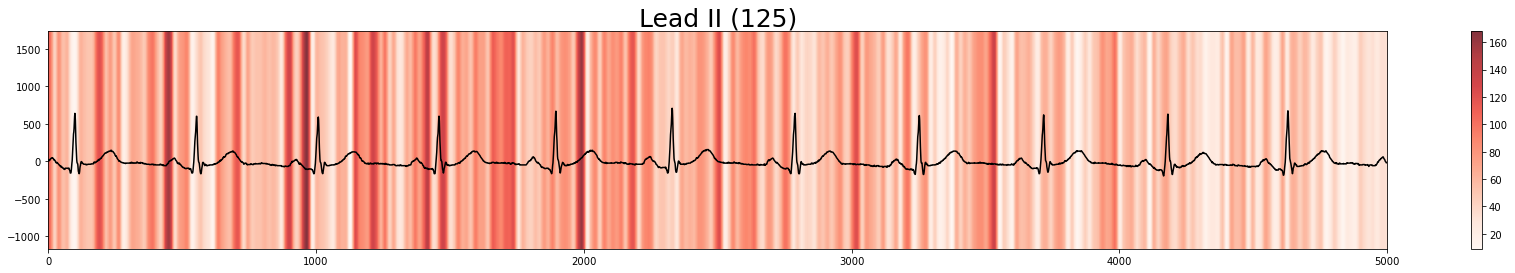

126


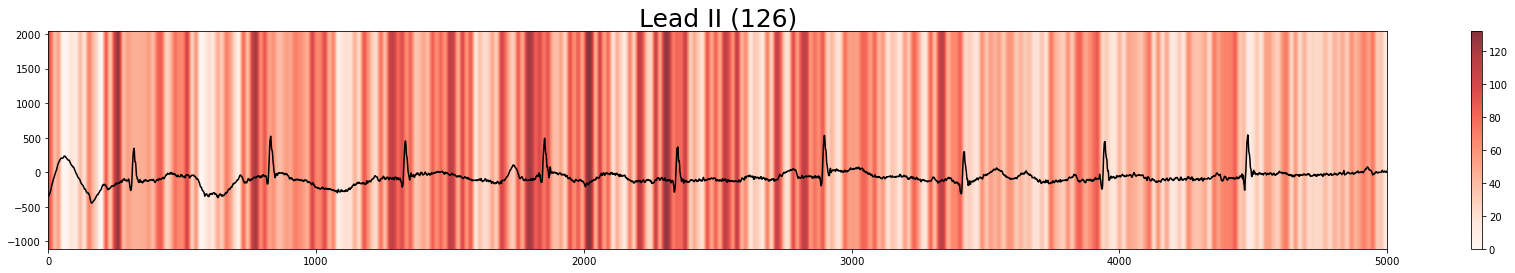

127


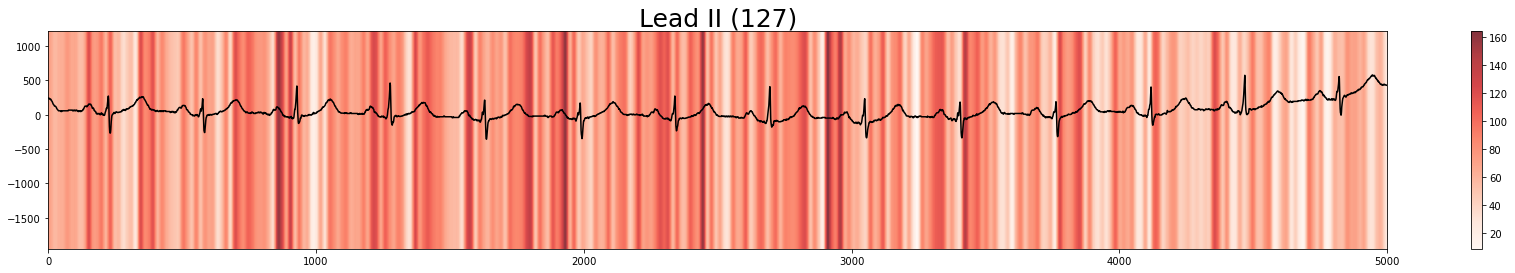

128


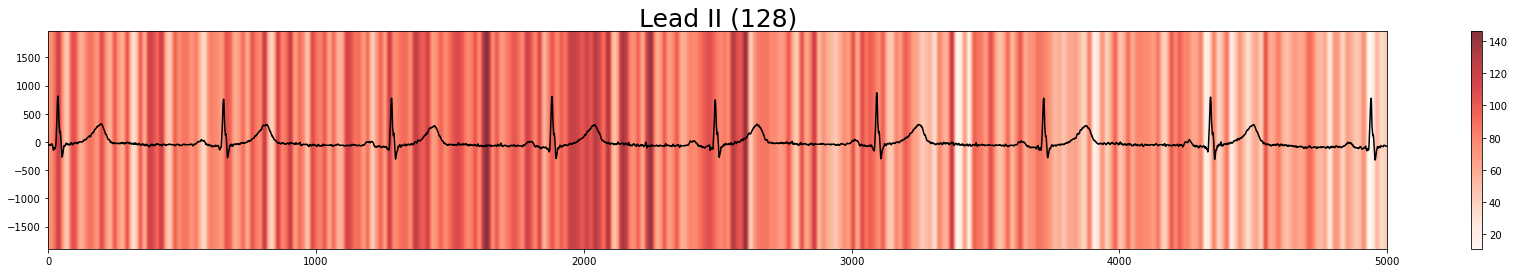

130


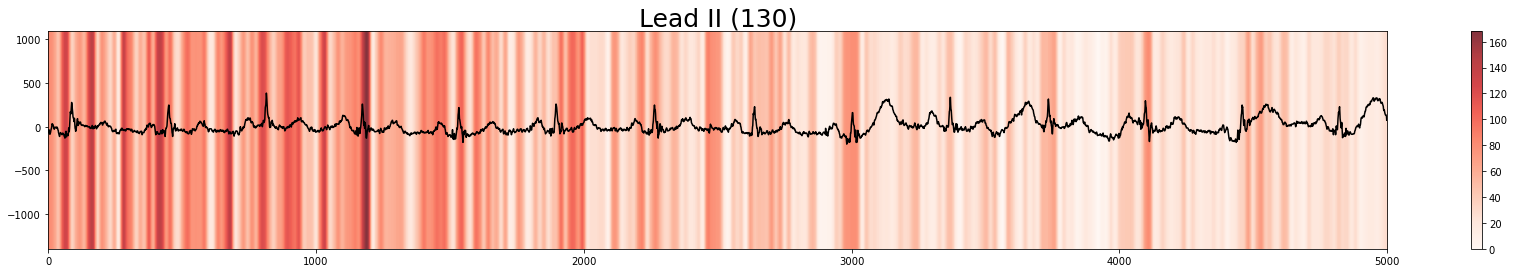

132


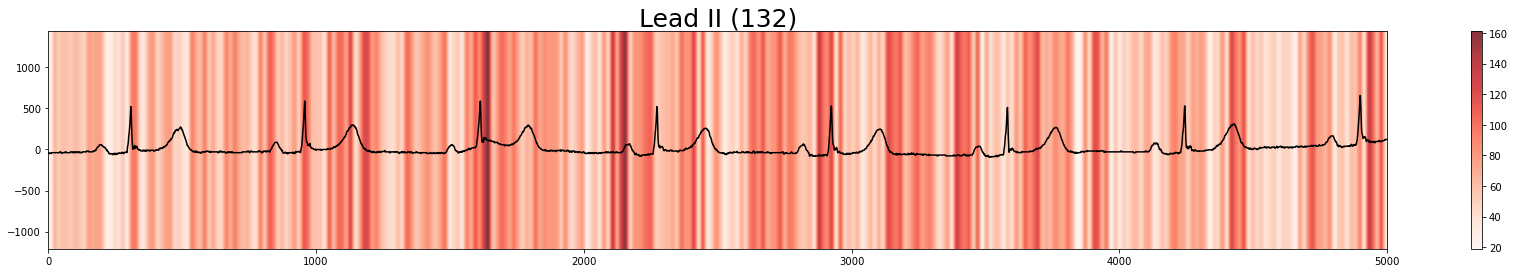

133


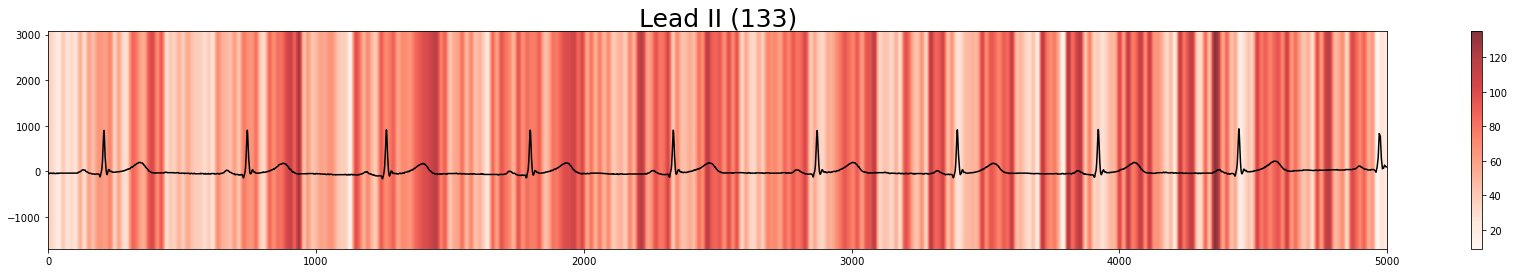

134


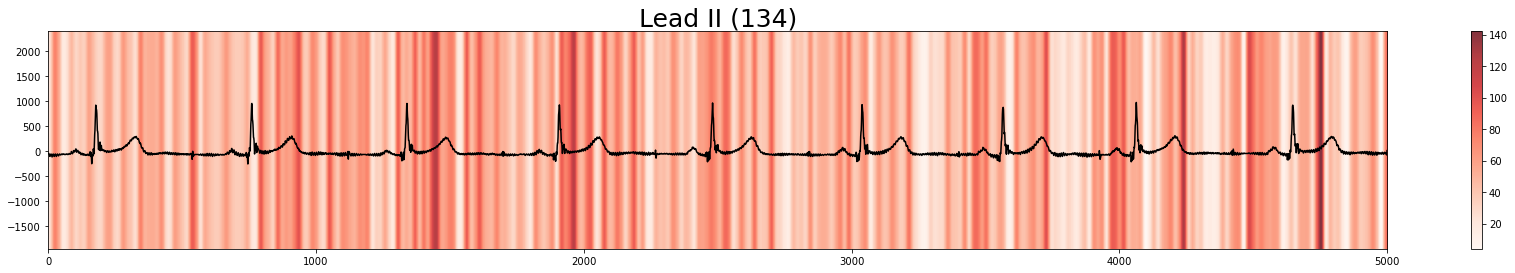

135


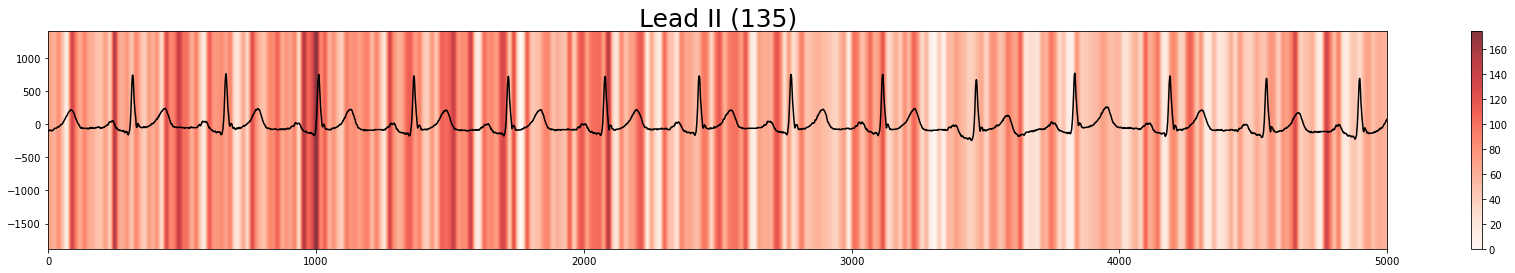

136


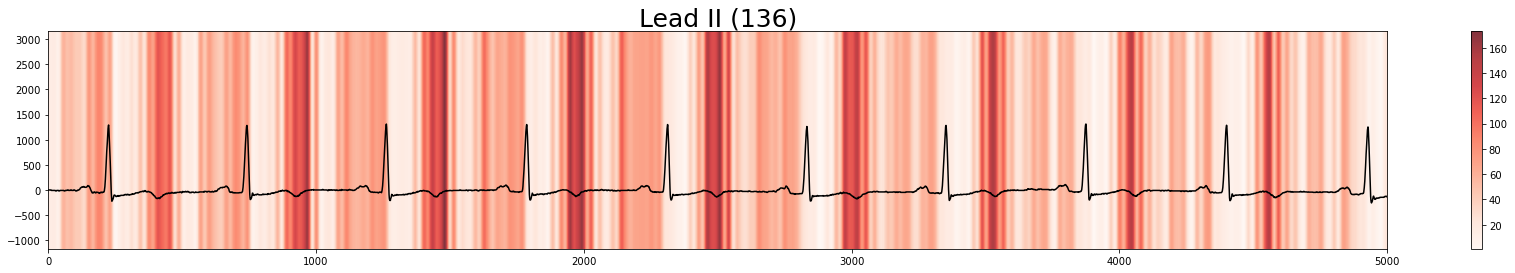

137


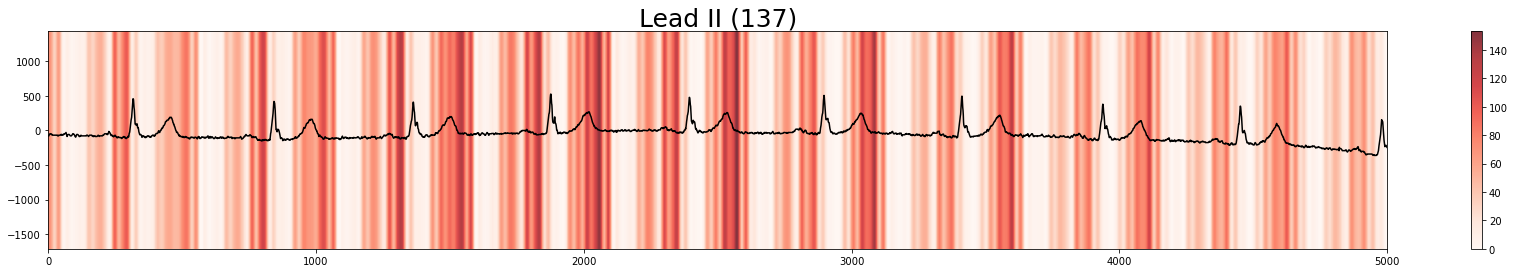

138


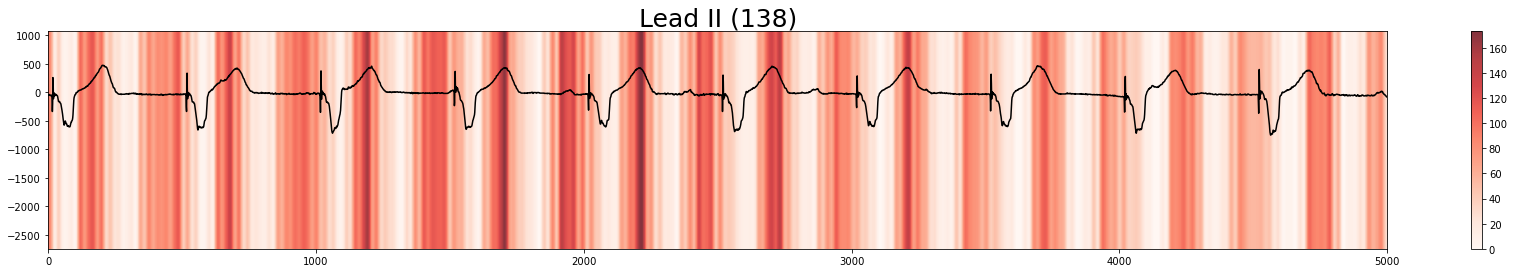

139


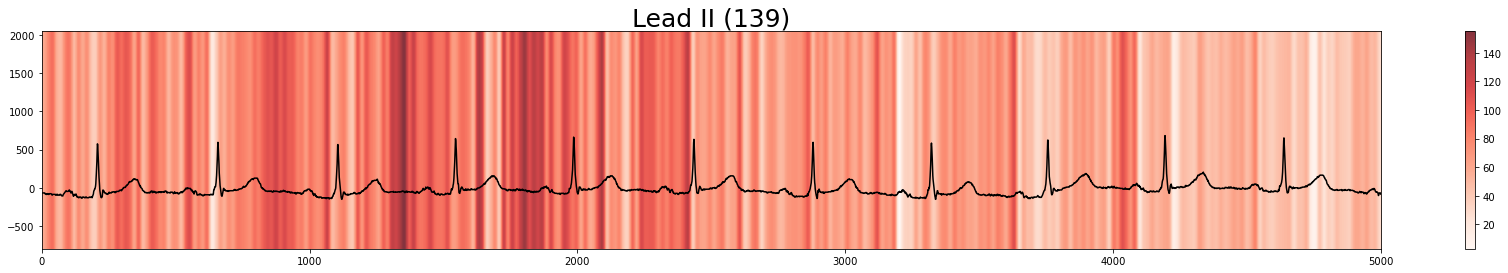

140


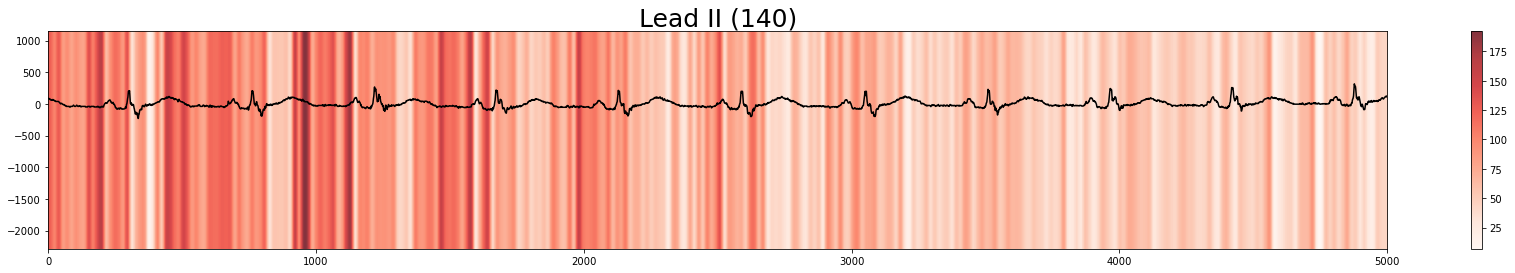

141


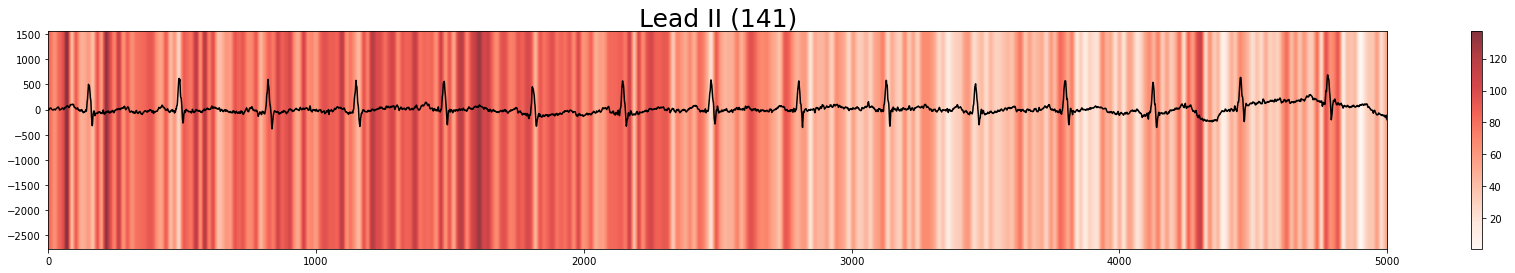

In [69]:
gcpercm(n_tn,1) # TN, lead II

# Check

In [14]:
outlier_idx = []
for idx, i in enumerate(X_test):
    for j in range(8):
        signal = i[:,j]
        count_outlier = np.count_nonzero(np.abs(signal) > 32766)
        if count_outlier >0:
            outlier_idx.append(idx)
outlier_idx

[39, 41, 400, 667, 667, 1170, 1170, 1228]